## Scripts of Md Ishtiak Rashid 
### Contains: 
### 1. Exploratory Data Analysis
    1.1 Variance Inflation Factor (VIF)
### 2. Anomaly Detection
    2.1. Preprocessing
    2.2 Isolation Forest on Carrier Samples
    2.3. Set threshold in Anomaly score
### 3. Classifier modeling
    3.1. Pre-processing
    3.2. Nested Cross-validation
    3.3. Prediction of Anomaly Carriers (Holdout set) using best classifier based on PRAUC score
    3.4. Predicted probability of HAM among Anomaly Carrier samples
### 4. Statistical Analysis
    4.1. Pre-processing
    4.2. Kruskal-Wallis test
### 5. Appendix
    5.1. Correlation between Feature values
    5.2. Contour plot of Anomaly score distribution among Carriers
    5.3. Anomaly score vs Feature value of Anomaly carriers
    5.4. Correlation between Feature values & Predicted probability of HAM among Anomaly carriers
### 6. Required packages

# 1. Exploratory Data Analysis

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline
import itertools
import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', RuntimeWarning)
warnings.simplefilter('ignore', UserWarning)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# load the data 
data = pd.read_csv('all_data_copy.csv', index_col=0)
data = data.replace('Carrier_to_ATL','ATL')
data = data.replace('Carrier_to_HAM','Carrier')

In [3]:
data.head()

PVL      Tax      Env  Gag p15    Gag p19    Gag p24     type
indivID                                                                  
indiv0001 4.600  520.000  272.000  260.000  99954.000  13909.000  Carrier
indiv0002 0.200 1628.000  126.000  172.000  27483.000   6809.000  Carrier
indiv0003 0.100 2238.000  290.000  156.000 151627.000 761360.000  Carrier
indiv0004 1.200 4787.000  726.000  422.000  42721.000 603196.000  Carrier
indiv0005 7.500  912.000 2292.000  278.000 948739.000 792544.000  Carrier

## 1.2. Variance Inflation Factor (VIF) Analysis

In [4]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [5]:
df = data.copy()
df.columns

Index(['PVL', 'Tax', 'Env', 'Gag p15', 'Gag p19', 'Gag p24', 'type'], dtype='object')

In [6]:
# variables
var_1 = df[['PVL', 'Tax', 'Env', 'Gag p15', 'Gag p19', 'Gag p24']]

In [7]:
# Calculate VIF
vif_data_1 = pd.DataFrame()
vif_data_1['Features'] = var_1.columns
vif_data_1['VIF score'] = [variance_inflation_factor(var_1.values, i) for i in range(var_1.shape[1])]

In [8]:
vif_data_1

Features  VIF score
0      PVL      1.145
1      Tax      1.634
2      Env      3.042
3  Gag p15      1.314
4  Gag p19      7.481
5  Gag p24      6.141

In [9]:
df.drop('Gag p19', axis=1, inplace=True)

In [10]:
var_2 = df[['PVL', 'Tax', 'Env', 'Gag p15', 'Gag p24']]

In [11]:
# Calculate VIF
vif_data_2 = pd.DataFrame()
vif_data_2['Features'] = var_2.columns
vif_data_2['VIF score'] = [variance_inflation_factor(var_2.values, i) for i in range(var_2.shape[1])]

In [12]:
vif_data_2

Features  VIF score
0      PVL      1.110
1      Tax      1.631
2      Env      2.462
3  Gag p15      1.293
4  Gag p24      2.794

# 2. Anomaly Detection

## 2.1. Preprocessing

In [13]:
data.head()

PVL      Tax      Env  Gag p15    Gag p19    Gag p24     type
indivID                                                                  
indiv0001 4.600  520.000  272.000  260.000  99954.000  13909.000  Carrier
indiv0002 0.200 1628.000  126.000  172.000  27483.000   6809.000  Carrier
indiv0003 0.100 2238.000  290.000  156.000 151627.000 761360.000  Carrier
indiv0004 1.200 4787.000  726.000  422.000  42721.000 603196.000  Carrier
indiv0005 7.500  912.000 2292.000  278.000 948739.000 792544.000  Carrier

In [14]:
data['target'] = data['type'].map({'Carrier': 0, 'ATL': 1, 'HAM': 2})

In [15]:
datad = data.copy()

In [16]:
datad.drop('Gag p19', axis=1, inplace=True)

In [17]:
carrier_data = datad[datad['target']==0]

In [18]:
carrier_data.columns

Index(['PVL', 'Tax', 'Env', 'Gag p15', 'Gag p24', 'type', 'target'], dtype='object')

In [19]:
X_carrier = carrier_data.drop(['type','target'], axis=1)

In [20]:
X_carrier.shape

(264, 5)

In [21]:
X_carrier.columns

Index(['PVL', 'Tax', 'Env', 'Gag p15', 'Gag p24'], dtype='object')

In [22]:
import sklearn
sklearn.__version__

'1.5.2'

## 2.2. Isolation Forest on Carrier samples

In [23]:
from sklearn.ensemble import IsolationForest

In [24]:
# Isolation Forest model 
iforest = IsolationForest(contamination= 'auto', max_samples = 'auto', n_estimators= 300, random_state= 42)

In [25]:
iforest.fit(X_carrier)

IsolationForest(n_estimators=300, random_state=42)

In [26]:
# anomaly score
anomaly_scores_carrier = iforest.decision_function(X_carrier)

In [27]:
min_anomaly= anomaly_scores_carrier.min()
max_anomaly= anomaly_scores_carrier.max()

In [28]:
print(min_anomaly)
print(max_anomaly)

-0.2273102462372898
0.15105609123304709


## 2.3. Set threshold in Anomaly score

In [29]:
# set threshold
threshold = -0.05

# indices of actual anomalies
anomaly_indices_carrier = [index for index, score in enumerate(anomaly_scores_carrier) if score <= threshold]

# Get the actual anomalies from dataset
actual_anomalies_carrier = X_carrier.iloc[anomaly_indices_carrier]

In [30]:
len(actual_anomalies_carrier)

17

In [31]:
anomalous_data_carrier = actual_anomalies_carrier.copy()

# get the index rows 
anomalous_indices_carrier = anomalous_data_carrier.index

# new df excluding the anomaly samples
clean_df = datad.drop(anomalous_indices_carrier)

In [99]:
actual_anomalies_carrier.loc[:, 'Anomaly_Score'] = anomaly_scores_carrier[anomaly_indices_carrier]

In [100]:
anomaly_scores_carrier_plot = np.sort(anomaly_scores_carrier)

In [102]:
actual_anomalies_carrier

PVL        Tax       Env    Gag p15      Gag p24  Anomaly_Score
indivID                                                                     
indiv0027 35.100  46360.600  8036.570 133435.500  9186793.000         -0.227
indiv0035 46.300   6257.360  3380.860   1392.000   557465.700         -0.107
indiv0069  2.730   5475.765  6935.648 334938.483 10298208.940         -0.206
indiv0086  2.800  85900.225  4353.480   9175.320  7825533.156         -0.135
indiv0125  3.520  24760.560  9624.000 143221.032 10627154.150         -0.143
indiv0131  1.890   9997.350 10307.304 156990.407  8509020.982         -0.110
indiv0133  1.540   6710.417  2773.046  62421.852  7597349.424         -0.051
indiv0169  2.790  73261.680 10899.912 156270.114  5645401.266         -0.160
indiv0189  0.360 112722.516  2923.854    365.620    14694.135         -0.113
indiv0217  7.090  40165.452  8748.922 232614.220  5608868.820         -0.136
indiv0221  9.790   5629.212 14189.266  89869.177  5905812.240         -0.133
indiv0227  7.160  65582.000 14497.938 264498.926  7607445.600         -0.215
indiv0240  7.490  12044.324  9279.452 127028.479  8400371.160         -0.087
indiv0245 23.470   1863.456  3303.802  44529.681  1584100.749         -0.051
indiv0249 11.550  76016.766  3491.858   8507.275   665555.814         -0.072
indiv0254  5.070  28942.788  5466.446 335210.855 10180285.420         -0.204
indiv0265 19.760  29540.545  7478.611  65475.192  4953871.651         -0.107

# 3. Classifier Modeling

## 3.1. Pre-processing

In [34]:
# Import necessary libraries
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import average_precision_score

In [35]:
clean_df.head()

PVL      Tax      Env  Gag p15    Gag p24     type  target
indivID                                                               
indiv0001 4.600  520.000  272.000  260.000  13909.000  Carrier       0
indiv0002 0.200 1628.000  126.000  172.000   6809.000  Carrier       0
indiv0003 0.100 2238.000  290.000  156.000 761360.000  Carrier       0
indiv0004 1.200 4787.000  726.000  422.000 603196.000  Carrier       0
indiv0005 7.500  912.000 2292.000  278.000 792544.000  Carrier       0

In [36]:
clean_df.shape

(352, 7)

In [37]:
# split for downsampling
data_carrier = clean_df[clean_df['type'] == 'Carrier']
data_ham = clean_df[clean_df['type'] == 'HAM']
data_atl = clean_df[clean_df['type'] == 'ATL']

In [38]:
# Downsample 100 carriers randomly
data_carrier_ds = data_carrier.sample(n=147, random_state=1) 

# Combine with other classes
clean_data_balanced = pd.concat([data_carrier_ds, data_ham, data_atl])

carrier_hold = data_carrier.drop(data_carrier_ds.index)

In [39]:
len(carrier_hold), len(clean_data_balanced)

(100, 252)

In [40]:
clean_data_balanced['type'].value_counts()

type
Carrier    147
HAM         56
ATL         49
Name: count, dtype: int64

In [41]:
from sklearn.utils.class_weight import compute_class_weight

In [42]:
# dynamic weight assignment after Downsampling

class_freq = list(clean_data_balanced["target"] )
class_weights = []

for i in range(3):
    
    altered_class_freq = []
    
    for j in class_freq:
    
        if i == j:
            altered_class_freq.append( 1 )
        else:
            altered_class_freq.append( 0 )
    
    class_weight = compute_class_weight(class_weight="balanced", classes=np.unique(altered_class_freq), y=altered_class_freq)

    class_weights.append( {0 : class_weight[0], 1 : class_weight[1]} )

class_weights

[{0: 1.2, 1: 0.8571428571428571},
 {0: 0.6206896551724138, 1: 2.5714285714285716},
 {0: 0.6428571428571429, 1: 2.25}]

## 3.2. Nested Cross-validation

In [43]:
# Set targets 
X = clean_data_balanced.drop(['type', 'target'], axis=1)
y = clean_data_balanced['target']

In [44]:
# Binarize target y
y_binarized = label_binarize(y, classes=np.unique(y))

# Setup inner & outer loops
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Define classifiers and param grids
classifiers_and_grids = {
    "RandomForest": (Pipeline([
        ('clf', RandomForestClassifier(random_state=42))
    ]), {
        'clf__n_estimators': [200, 400, 600],
        'clf__max_depth': [None, 5, 10],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4],
        'clf__max_features': ['log2', 'sqrt', None]
    }),
    "XGB": (Pipeline([
        ('clf', OneVsRestClassifier(XGBClassifier(eval_metric='logloss')))
    ]), {
        'clf__estimator__n_estimators': [200, 300, 400],
        'clf__estimator__max_depth': [3, 5, 10],
        'clf__estimator__learning_rate': [0.01, 0.05, 0.08],
        'clf__estimator__subsample': [0.8, 1.0],
        'clf__estimator__colsample_bytree': [0.8, 1.0]
    }),
    "ExtraTrees": (Pipeline([
        ('clf', ExtraTreesClassifier(random_state=1))
    ]), {
        'clf__n_estimators': [200, 300, 400],
        'clf__max_depth': [None, 5, 10],
        'clf__min_samples_split': [2, 5, 10],
        'clf__max_features': ['auto', 'sqrt', None]
    }),
    "SVM": (Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(decision_function_shape='ovr', probability=True, random_state=98))
    ]), {
        'clf__C': [0.1, 1, 10],
        'clf__kernel': ['linear', 'rbf'],
        'clf__gamma': ['scale', 'auto']
    })
}

In [45]:
# Nested cross-val.
def nested_cv_with_prauc(X, y_binarized):
    overall_results = {}
    best_model = None

    for model_name, (pipeline, param_grid) in classifiers_and_grids.items():
        print(f"\nEvaluating {model_name} with Nested Cross-Validation (PRAUC):")

        # store PRAUC 
        overall_prauc_scores = []
        overall_mean_prauc_per_class = []

        # OvR PRAUC for each class
        for class_idx in range(len(np.unique(y))):
            prauc_scores = []

            # dynamically update the class weights 
            if model_name != "XGB":  
                param_grid['clf__class_weight'] = [class_weights[class_idx]]

            for train_idx, test_idx in outer_cv.split(X, y):
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_test = y_binarized[train_idx, :], y_binarized[test_idx, :]

                # set inner loop gridsearch
                grid_search = GridSearchCV(
                    estimator=pipeline,
                    param_grid=param_grid,
                    cv=inner_cv,
                    scoring='average_precision',  
                    n_jobs=-1
                )
                grid_search.fit(X_train, y_train[:, class_idx])
                best_model_inner = grid_search.best_estimator_

                # outer loop test set predictions
                y_pred_proba = best_model_inner.predict_proba(X_test)[:, 1]
                prauc = average_precision_score(y_test[:, class_idx], y_pred_proba)
                prauc_scores.append(prauc)

            # Calculate mean and std PRAUC for the current class
            mean_prauc = np.mean(prauc_scores)
            std_prauc = np.std(prauc_scores)
            overall_prauc_scores.append((mean_prauc, std_prauc))
            overall_mean_prauc_per_class.append(mean_prauc)
            print(f"{model_name} - Class {class_idx}: Mean PRAUC = {mean_prauc:.3f} ± {std_prauc:.3f}")

        # Overall result for the model
        overall_mean_prauc = np.mean(overall_mean_prauc_per_class)
        print(f"{model_name} Overall Mean PRAUC (across all classes): {overall_mean_prauc:.3f}")

        if best_model is None or overall_mean_prauc > best_model["mean_prauc"]:
            best_model = {
                "name": model_name,
                "pipeline": pipeline,
                "mean_prauc": overall_mean_prauc
            }

    return best_model

In [46]:
# Train the best model on the full training data
def train_and_test_best_model_with_prauc(X_train, y_train, X_test, best_model):
    final_pipeline = best_model["pipeline"]
    final_pipeline.fit(X_train, y_train)  
    y_test_pred_proba = final_pipeline.predict_proba(X_test)
    return y_test_pred_proba

# Run nested-cv with PRAUC 
best_model = nested_cv_with_prauc(X, y_binarized)
print(f"\nBest Model: {best_model['name']} with Mean PRAUC = {best_model['mean_prauc']:.3f}")


Evaluating RandomForest with Nested Cross-Validation (PRAUC):
RandomForest - Class 0: Mean PRAUC = 0.912 ± 0.050
RandomForest - Class 1: Mean PRAUC = 0.815 ± 0.107
RandomForest - Class 2: Mean PRAUC = 0.794 ± 0.035
RandomForest Overall Mean PRAUC (across all classes): 0.841

Evaluating XGB with Nested Cross-Validation (PRAUC):
XGB - Class 0: Mean PRAUC = 0.906 ± 0.046
XGB - Class 1: Mean PRAUC = 0.805 ± 0.104
XGB - Class 2: Mean PRAUC = 0.747 ± 0.044
XGB Overall Mean PRAUC (across all classes): 0.819

Evaluating ExtraTrees with Nested Cross-Validation (PRAUC):
ExtraTrees - Class 0: Mean PRAUC = 0.910 ± 0.042
ExtraTrees - Class 1: Mean PRAUC = 0.817 ± 0.118
ExtraTrees - Class 2: Mean PRAUC = 0.791 ± 0.064
ExtraTrees Overall Mean PRAUC (across all classes): 0.839

Evaluating SVM with Nested Cross-Validation (PRAUC):
SVM - Class 0: Mean PRAUC = 0.911 ± 0.056
SVM - Class 1: Mean PRAUC = 0.788 ± 0.133
SVM - Class 2: Mean PRAUC = 0.735 ± 0.086
SVM Overall Mean PRAUC (across all classes): 0.

In [47]:
best_model

{'name': 'RandomForest',
 'pipeline': Pipeline(steps=[('clf', RandomForestClassifier(random_state=42))]),
 'mean_prauc': 0.8406398681471128}

## 3.3. Prediction of Anomaly Carriers (Holdout set) using best classifier based on PRAUC score

In [48]:
anomalous_data_carrier.head()

PVL       Tax      Env    Gag p15      Gag p24
indivID                                                    
indiv0027 35.100 46360.600 8036.570 133435.500  9186793.000
indiv0035 46.300  6257.360 3380.860   1392.000   557465.700
indiv0069  2.730  5475.765 6935.648 334938.483 10298208.940
indiv0086  2.800 85900.225 4353.480   9175.320  7825533.156
indiv0125  3.520 24760.560 9624.000 143221.032 10627154.150

In [49]:
# Prepare the data
test_anomaly_carrier = anomalous_data_carrier.copy()

test_anomaly_carrier.head()

PVL       Tax      Env    Gag p15      Gag p24
indivID                                                    
indiv0027 35.100 46360.600 8036.570 133435.500  9186793.000
indiv0035 46.300  6257.360 3380.860   1392.000   557465.700
indiv0069  2.730  5475.765 6935.648 334938.483 10298208.940
indiv0086  2.800 85900.225 4353.480   9175.320  7825533.156
indiv0125  3.520 24760.560 9624.000 143221.032 10627154.150

In [50]:
y_pred_unseen = train_and_test_best_model_with_prauc(X, y_binarized, test_anomaly_carrier, best_model)

# Combined probabilities
combined_proba = np.array([pred[:, 1] for pred in y_pred_unseen]).T 

# final predictions
y_pred_anomaly = np.argmax(combined_proba, axis=1)
y_pred_anomaly

array([2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 0, 2, 2])

In [51]:
# Make dataframe of anomaly samples with respective predicted classes
anomaly_pred_result = pd.DataFrame(data=test_anomaly_carrier, columns=test_anomaly_carrier.columns)

# add the predicted class column
anomaly_pred_result['Predicted_class'] = ['ATL' if pred == 1 else ('HAM' if pred == 2 else 'Carrier') for pred in y_pred_anomaly]

In [52]:
anomaly_pred_result

PVL        Tax       Env    Gag p15      Gag p24 Predicted_class
indivID                                                                      
indiv0027 35.100  46360.600  8036.570 133435.500  9186793.000             HAM
indiv0035 46.300   6257.360  3380.860   1392.000   557465.700             ATL
indiv0069  2.730   5475.765  6935.648 334938.483 10298208.940             HAM
indiv0086  2.800  85900.225  4353.480   9175.320  7825533.156             HAM
indiv0125  3.520  24760.560  9624.000 143221.032 10627154.150             HAM
indiv0131  1.890   9997.350 10307.304 156990.407  8509020.982             HAM
indiv0133  1.540   6710.417  2773.046  62421.852  7597349.424             HAM
indiv0169  2.790  73261.680 10899.912 156270.114  5645401.266             HAM
indiv0189  0.360 112722.516  2923.854    365.620    14694.135         Carrier
indiv0217  7.090  40165.452  8748.922 232614.220  5608868.820             HAM
indiv0221  9.790   5629.212 14189.266  89869.177  5905812.240             HAM
indiv0227  7.160  65582.000 14497.938 264498.926  7607445.600             HAM
indiv0240  7.490  12044.324  9279.452 127028.479  8400371.160             HAM
indiv0245 23.470   1863.456  3303.802  44529.681  1584100.749             ATL
indiv0249 11.550  76016.766  3491.858   8507.275   665555.814         Carrier
indiv0254  5.070  28942.788  5466.446 335210.855 10180285.420             HAM
indiv0265 19.760  29540.545  7478.611  65475.192  4953871.651             HAM

In [53]:
anomaly_pred_result["Predicted_class"].value_counts()

Predicted_class
HAM        13
ATL         2
Carrier     2
Name: count, dtype: int64

## 3.4. Predicted probability of HAM among Anomaly Carrier samples

In [54]:
all_params = best_model["pipeline"]["clf"].get_params()

In [55]:
clf = RandomForestClassifier(**all_params)
clf.fit(X, y)  

RandomForestClassifier(random_state=42)

In [56]:
pp_ac = anomalous_data_carrier.copy()

In [57]:
##pp_ac.drop('Anomaly_Score', axis=1, inplace=True)

In [58]:
y_pp_ac = clf.predict_proba(pp_ac)[:,2]

In [59]:
AC_pp_result = pd.DataFrame(data= pp_ac)
AC_pp_result['probability_positive_HAM'] = y_pp_ac

In [60]:
AC_pp_result.head()

PVL       Tax      Env    Gag p15      Gag p24  \
indivID                                                       
indiv0027 35.100 46360.600 8036.570 133435.500  9186793.000   
indiv0035 46.300  6257.360 3380.860   1392.000   557465.700   
indiv0069  2.730  5475.765 6935.648 334938.483 10298208.940   
indiv0086  2.800 85900.225 4353.480   9175.320  7825533.156   
indiv0125  3.520 24760.560 9624.000 143221.032 10627154.150   

           probability_positive_HAM  
indivID                              
indiv0027                     0.810  
indiv0035                     0.000  
indiv0069                     0.700  
indiv0086                     0.700  
indiv0125                     0.720

## 3.5. Plot on PLS

In [61]:
from sklearn.cross_decomposition import PLSRegression

In [62]:
# Load the data
df = data.copy()
df.drop('target', axis=1, inplace=True)
df = df[df['type'].isin(['Carrier', 'ATL', 'HAM'])]

In [63]:
# log transformation on numeric columns
data_log = np.log1p(df.select_dtypes(include=[np.number]))

In [64]:
# class mappings and one-hot encode labels
class_num = {'Carrier': 0, 'ATL': 1, 'HAM': 2}
data_y = np.zeros((len(df), len(class_num)))
for i, label in enumerate(df['type']):
    data_y[i, class_num[label]] = 1

# Select features
data_x = data_log[['PVL', 'Tax', 'Env', 'Gag p15', 'Gag p19', 'Gag p24']]

# fit PLS Regression
pls = PLSRegression(n_components=2)
pls_fit = pls.fit(data_x, data_y)
pls_score = pls_fit.x_scores_

# Store results in DataFrame
df_pls = pd.DataFrame(pls_score, columns=['axis01', 'axis02'])
df_pls['type'] = df['type'].values
df_pls['indivID'] = df.index

# Define anomalous individuals and CDH
anomalous_indices_carrier = [
    'indiv0027', 'indiv0035', 'indiv0069', 'indiv0086', 'indiv0125',
    'indiv0131', 'indiv0133', 'indiv0169', 'indiv0189', 'indiv0217',
    'indiv0221', 'indiv0227', 'indiv0240', 'indiv0245', 'indiv0249',
    'indiv0254', 'indiv0265'
]
CDH_df_pls = df_pls[df_pls["indivID"] == "indiv0265"]

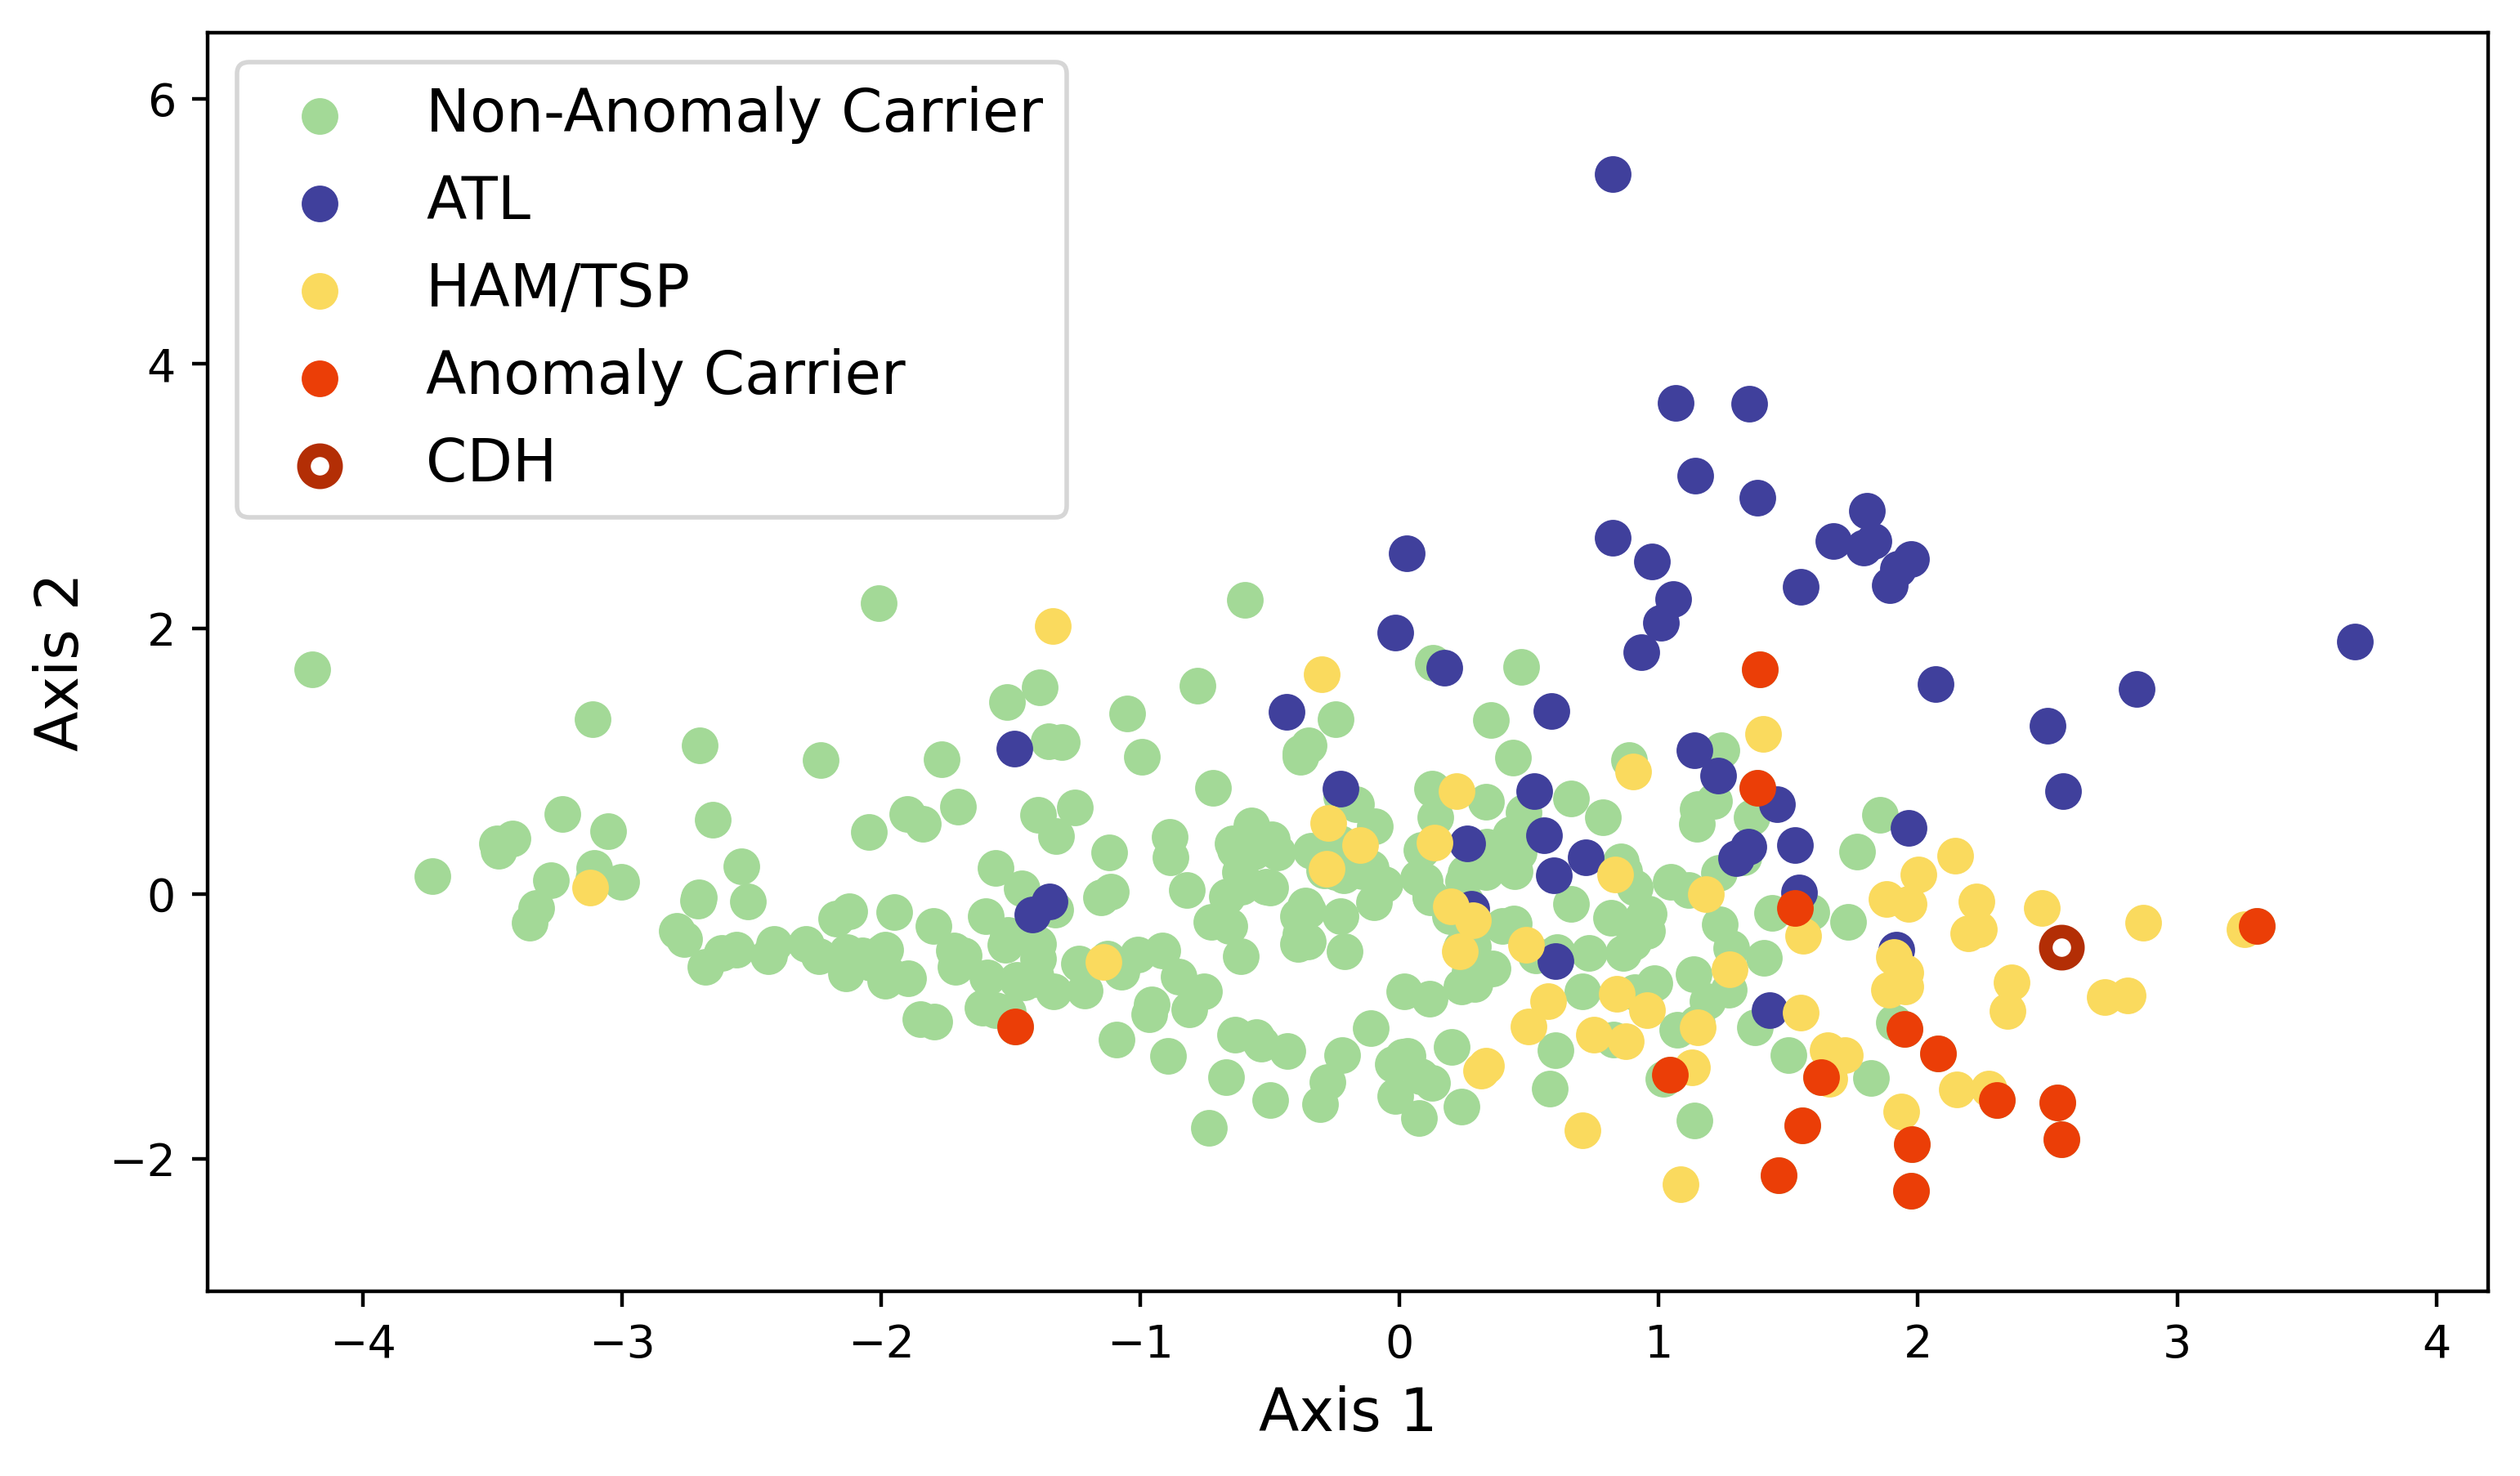

In [65]:
# color list and labels
color_list = {
    'Carrier': '#A3D997', 'ATL': '#40409C', 'HAM': '#fada5e', 
    'Anomaly Carrier': '#eb3e07', 'CDH': '#B32E05'
}
class_label = {'Carrier': 'Non-Anomaly Carrier', 'ATL': 'ATL', 'HAM': 'HAM/TSP'}

# plot results
fig, ax = plt.subplots(figsize=(9, 5), dpi=400)

for i_class in ['Carrier', 'ATL', 'HAM']:
    subset = df_pls[df_pls['type'] == i_class]
    ax.scatter(subset['axis01'], subset['axis02'], color=color_list[i_class], s=50, label=class_label[i_class])

# Plot anomaly carriers
anomalous_subset = df_pls[df_pls["indivID"].isin(anomalous_indices_carrier)]
ax.scatter(anomalous_subset['axis01'], anomalous_subset['axis02'], s=50, color=color_list["Anomaly Carrier"], label="Anomaly Carrier")

# highlight CDH
ax.scatter(CDH_df_pls["axis01"], CDH_df_pls["axis02"], s=50, fc="white", ec=color_list["CDH"], linewidth=3, label="CDH")

# final plot 
plt.legend(loc='upper left', fontsize=13)
plt.xlabel('Axis 1', fontsize=13)
plt.ylabel('Axis 2', fontsize=13)
plt.xlim(-4.6, 4.2)
plt.ylim(-3, 6.5)
plt.show()

# 4. Statistical Analysis

## 4.1. Pre-processing

In [66]:
stat_df = data.copy()

In [67]:
stat_df.drop('target', axis=1, inplace=True)

In [68]:
anomalous_indices_carrier = [
    'indiv0027', 'indiv0035', 'indiv0069', 'indiv0086', 'indiv0125',
    'indiv0131', 'indiv0133', 'indiv0169', 'indiv0189', 'indiv0217',
    'indiv0221', 'indiv0227', 'indiv0240', 'indiv0245', 'indiv0249',
    'indiv0254', 'indiv0265'
]

In [69]:
# add anomaly carriers to the type & update the dataframe
stat_df.loc[anomalous_indices_carrier, 'type'] = stat_df.loc[anomalous_indices_carrier, 'type'].replace('Carrier', 'Anomaly carrier')

In [70]:
stat_df["type"].value_counts()

type
Carrier            247
HAM                 56
ATL                 49
Anomaly carrier     17
Name: count, dtype: int64

## 4.2. Kruskal-Wallis test

In [71]:
import scipy.stats as stats
import scikit_posthocs as sp

In [72]:
random_seed = 42

group_names = ['Carrier', 'ATL', 'HAM', 'Anomaly carrier']

groups = [stat_df[stat_df['type'] == group_name] for group_name in group_names]

combined_data = pd.concat(groups)

# store test results
kruskal_results = {}
posthoc_p_values = {}

#features
numerical_features = ['PVL', 'Tax', 'Env', 'Gag p15', 'Gag p19', 'Gag p24']

In [73]:
# KW analysis
for feature in numerical_features:
    kruskal_statistic, p_value = stats.kruskal(
        *[combined_data[combined_data['type'] == type][feature] for type in group_names]
    )
    kruskal_results[feature] = {'Kruskal Statistic': kruskal_statistic, 'p-value': p_value}

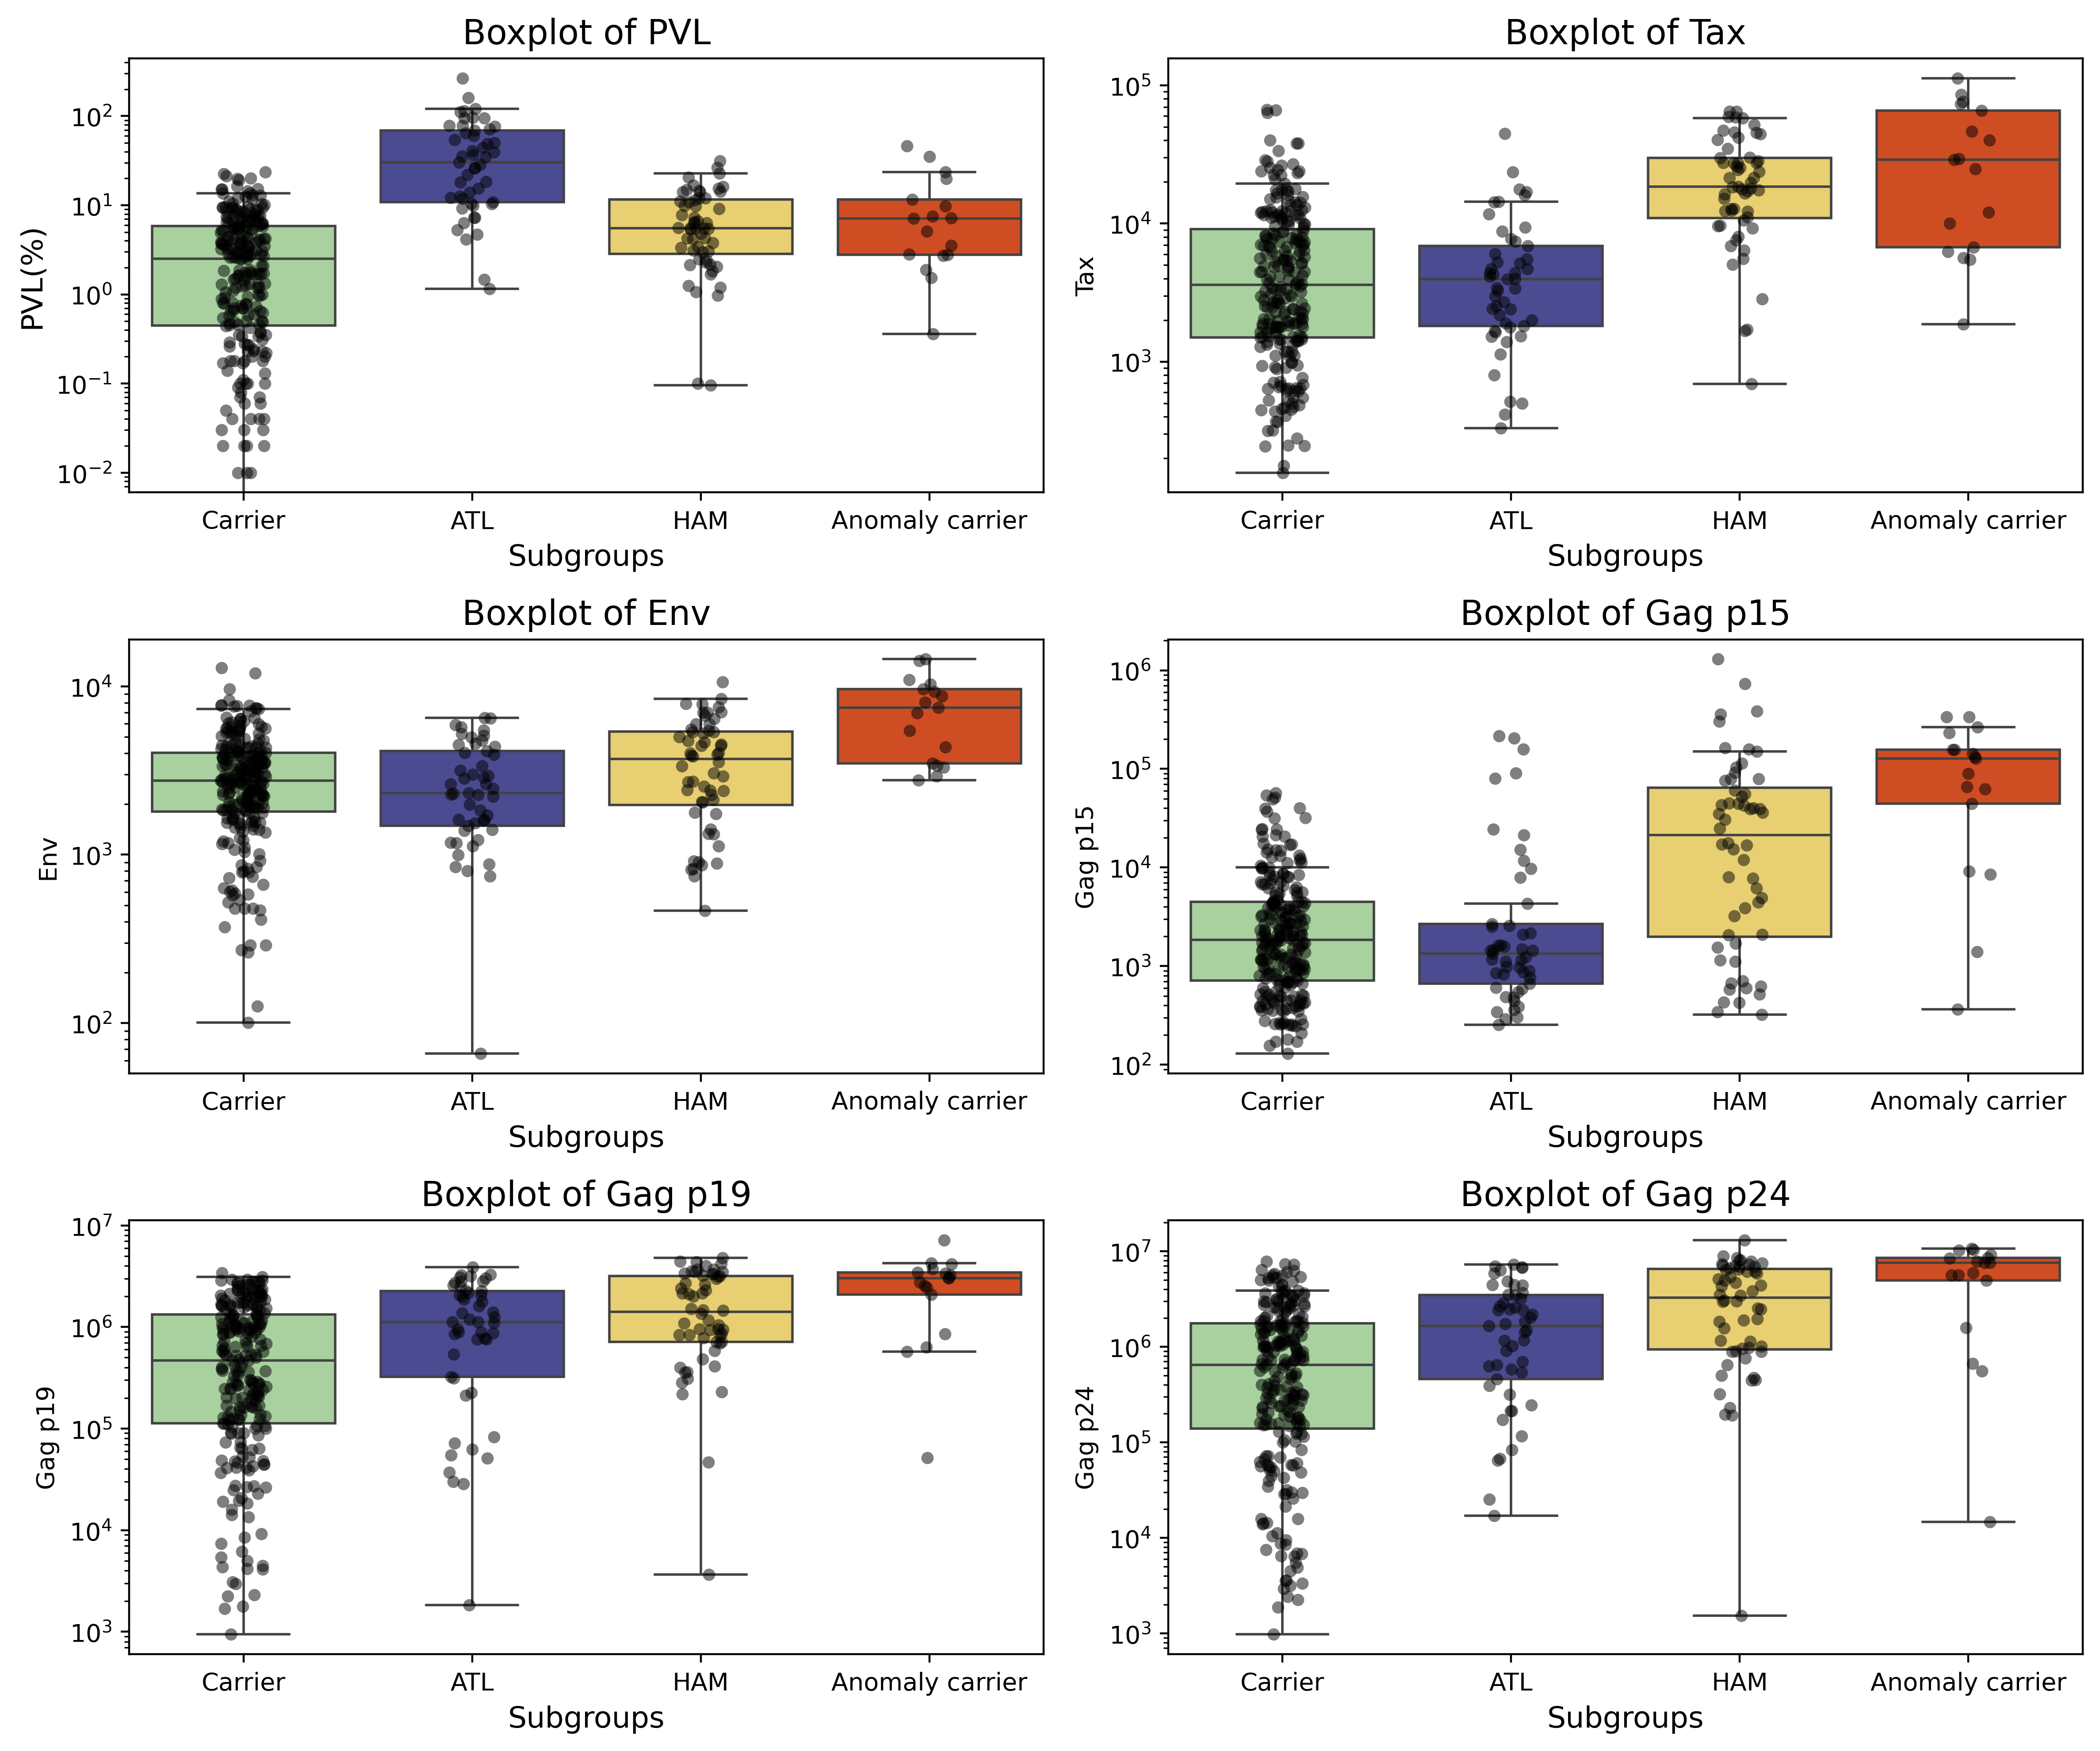

In [74]:
# Visualization of KW

plt.figure(figsize=(12, 10), dpi=400)
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(x='type', y=feature, data=combined_data, palette=["#A3D997", "#40409C", "#FADA5E", "#EB3E07"], showfliers=False)
    sns.stripplot(x='type', y=feature, data=combined_data, color='black', alpha=0.5, jitter=True)
    
    # Set title with larger font size
    plt.title(f'Boxplot of {feature}', fontsize=14)
    
    # Set y-axis label with larger font size
    if i == 0:
        plt.ylabel('PVL(%)', fontsize=12)
    
    # Set x-axis label with larger font size
    plt.xlabel('Subgroups', fontsize=12)
    
    plt.yscale('log')
    
plt.tight_layout()
plt.show()

In [75]:
# Print Kruskal-Wallis test results
for feature, result in kruskal_results.items():
    print(f'Kruskal-Wallis Test for {feature}:')
    print(f'Kruskal Statistic: {result["Kruskal Statistic"]:.4f}')
    print(f'p-value: {result["p-value"]:.4f}')
    print('\n')

Kruskal-Wallis Test for PVL:
Kruskal Statistic: 111.6197
p-value: 0.0000


Kruskal-Wallis Test for Tax:
Kruskal Statistic: 85.7361
p-value: 0.0000


Kruskal-Wallis Test for Env:
Kruskal Statistic: 28.1111
p-value: 0.0000


Kruskal-Wallis Test for Gag p15:
Kruskal Statistic: 59.4299
p-value: 0.0000


Kruskal-Wallis Test for Gag p19:
Kruskal Statistic: 55.4303
p-value: 0.0000


Kruskal-Wallis Test for Gag p24:
Kruskal Statistic: 66.4650
p-value: 0.0000




In [76]:
# dunn's post hoc test
for feature in numerical_features:
    posthoc_p_value = sp.posthoc_dunn(
        combined_data, val_col=feature, group_col='type', p_adjust='bonferroni'
    )
    posthoc_p_values[feature] = posthoc_p_value

# Print results
for feature, p_values in posthoc_p_values.items():
    print(f"Dunn's Test for {feature}:")
    for i, group1 in enumerate(group_names):
        for j, group2 in enumerate(group_names):
            if i < j:
                p_value = p_values.loc[group1, group2]
                if p_value < 0.05:
                    print(f"    {group1} vs. {group2}: Significant (p = {p_value:.4f})")
                else:
                    print(f"    {group1} vs. {group2}: Not Significant (p = {p_value:.4f})")
    print('\n')

Dunn's Test for PVL:
    Carrier vs. ATL: Significant (p = 0.0000)
    Carrier vs. HAM: Significant (p = 0.0000)
    Carrier vs. Anomaly carrier: Significant (p = 0.0197)
    ATL vs. HAM: Significant (p = 0.0000)
    ATL vs. Anomaly carrier: Significant (p = 0.0190)
    HAM vs. Anomaly carrier: Not Significant (p = 1.0000)


Dunn's Test for Tax:
    Carrier vs. ATL: Not Significant (p = 1.0000)
    Carrier vs. HAM: Significant (p = 0.0000)
    Carrier vs. Anomaly carrier: Significant (p = 0.0000)
    ATL vs. HAM: Significant (p = 0.0000)
    ATL vs. Anomaly carrier: Significant (p = 0.0001)
    HAM vs. Anomaly carrier: Not Significant (p = 1.0000)


Dunn's Test for Env:
    Carrier vs. ATL: Not Significant (p = 1.0000)
    Carrier vs. HAM: Not Significant (p = 0.3102)
    Carrier vs. Anomaly carrier: Significant (p = 0.0000)
    ATL vs. HAM: Not Significant (p = 0.1995)
    ATL vs. Anomaly carrier: Significant (p = 0.0000)
    HAM vs. Anomaly carrier: Significant (p = 0.0048)


Dunn's 

# 5. Appendix

In [77]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr

In [78]:
data = pd.read_csv('all_data_copy.csv', index_col=0)
data = data.replace('Carrier_to_ATL','ATL')
data = data.replace('Carrier_to_HAM','Carrier')

## 5.1. Correlation between feature values

In [79]:
df_corr = data.copy()
df_corr.drop('type', axis=1, inplace=True)

corr = df_corr.corr(method='spearman')

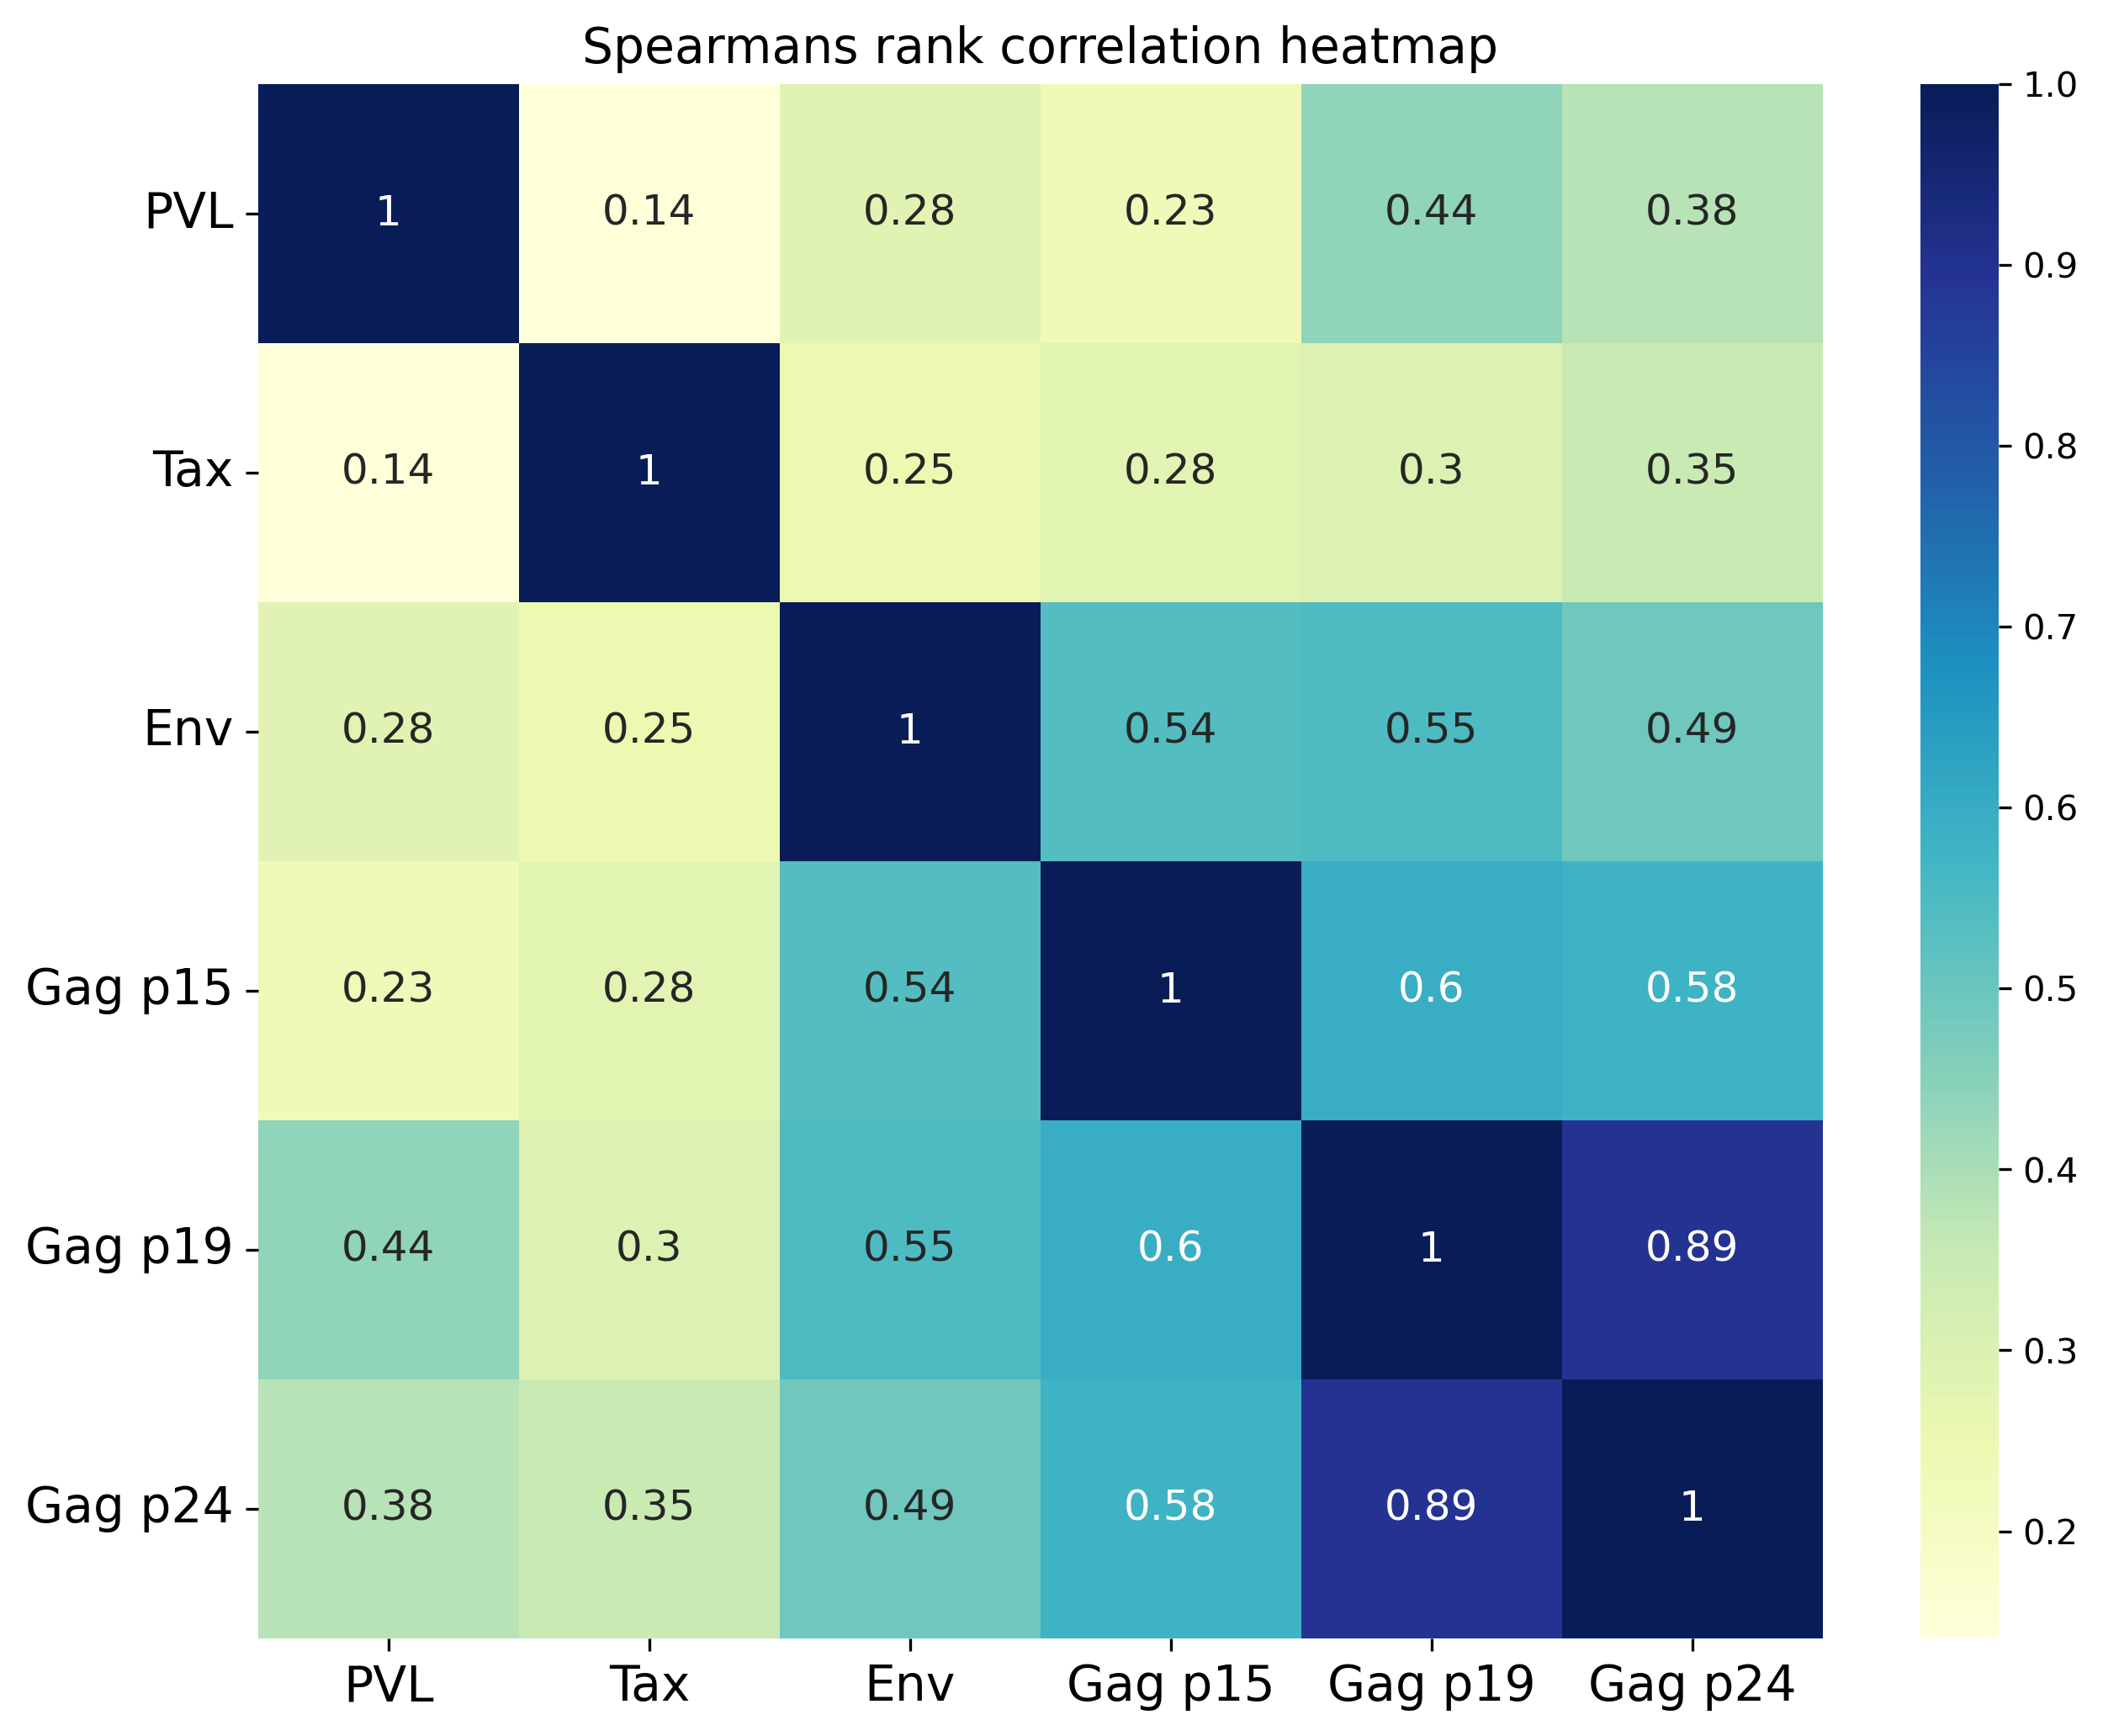

In [80]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
heatmap = sns.heatmap(corr, cmap='YlGnBu', annot=True, annot_kws={'size': 12}, ax=ax)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=14)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=14, rotation=0)
plt.title('Spearmans rank correlation heatmap', fontsize=14)
plt.show()

In [81]:
rho_1, p_1 = spearmanr(df_corr['Gag p24'], df_corr['Gag p19'])
rho_2, p_2 = spearmanr(df_corr['Gag p15'], df_corr['Gag p19'])
rho_3, p_3 = spearmanr(df_corr['Gag p15'], df_corr['Gag p24'])
rho_4, p_4 = spearmanr(df_corr['Gag p19'], df_corr['Env'])
rho_5, p_5 = spearmanr(df_corr['Gag p15'], df_corr['Env'])

In [82]:
print(rho_1), print(rho_2), print(rho_3), print(rho_4), print(rho_5)

0.8945945945945947
0.5951554824867404
0.5802632652152545
0.5500548912046288
0.5393983210080353


(None, None, None, None, None)

In [83]:
print(p_1), print(p_2), print(p_3), print(p_4), print(p_5)

1.93629122596502e-130
9.86986348213727e-37
1.3693876740743134e-34
1.4444299619691229e-30
3.0459400422368776e-29


(None, None, None, None, None)

## 5.2. Contour plot of Anomaly Score distribution among Carriers

In [84]:
from scipy.interpolate import griddata

# Copy X_carrier and add anomaly scores
carrier_log = X_carrier.copy()
carrier_log['Anomaly_Score'] = anomaly_scores_carrier

# Create DataFrame with PLS scores
df_pls = pd.DataFrame(pls_score, columns=['axis01', 'axis02'], index=data.index)
df_pls['type'] = data['type']

# Filter only Carriers
pls_carriers = df_pls[df_pls['type'] == 'Carrier'].copy()
pls_carriers.reset_index(inplace=False)
pls_carriers.drop(columns=['type'], inplace=True)

# Merge Anomaly Scores to pls score
pls_carriers['Anomaly_Score'] = carrier_log.iloc[:, -1] 

# Extract feature values for contour plot
feature_x = pls_carriers['axis01']
feature_y = pls_carriers['axis02']
Z = pls_carriers['Anomaly_Score']

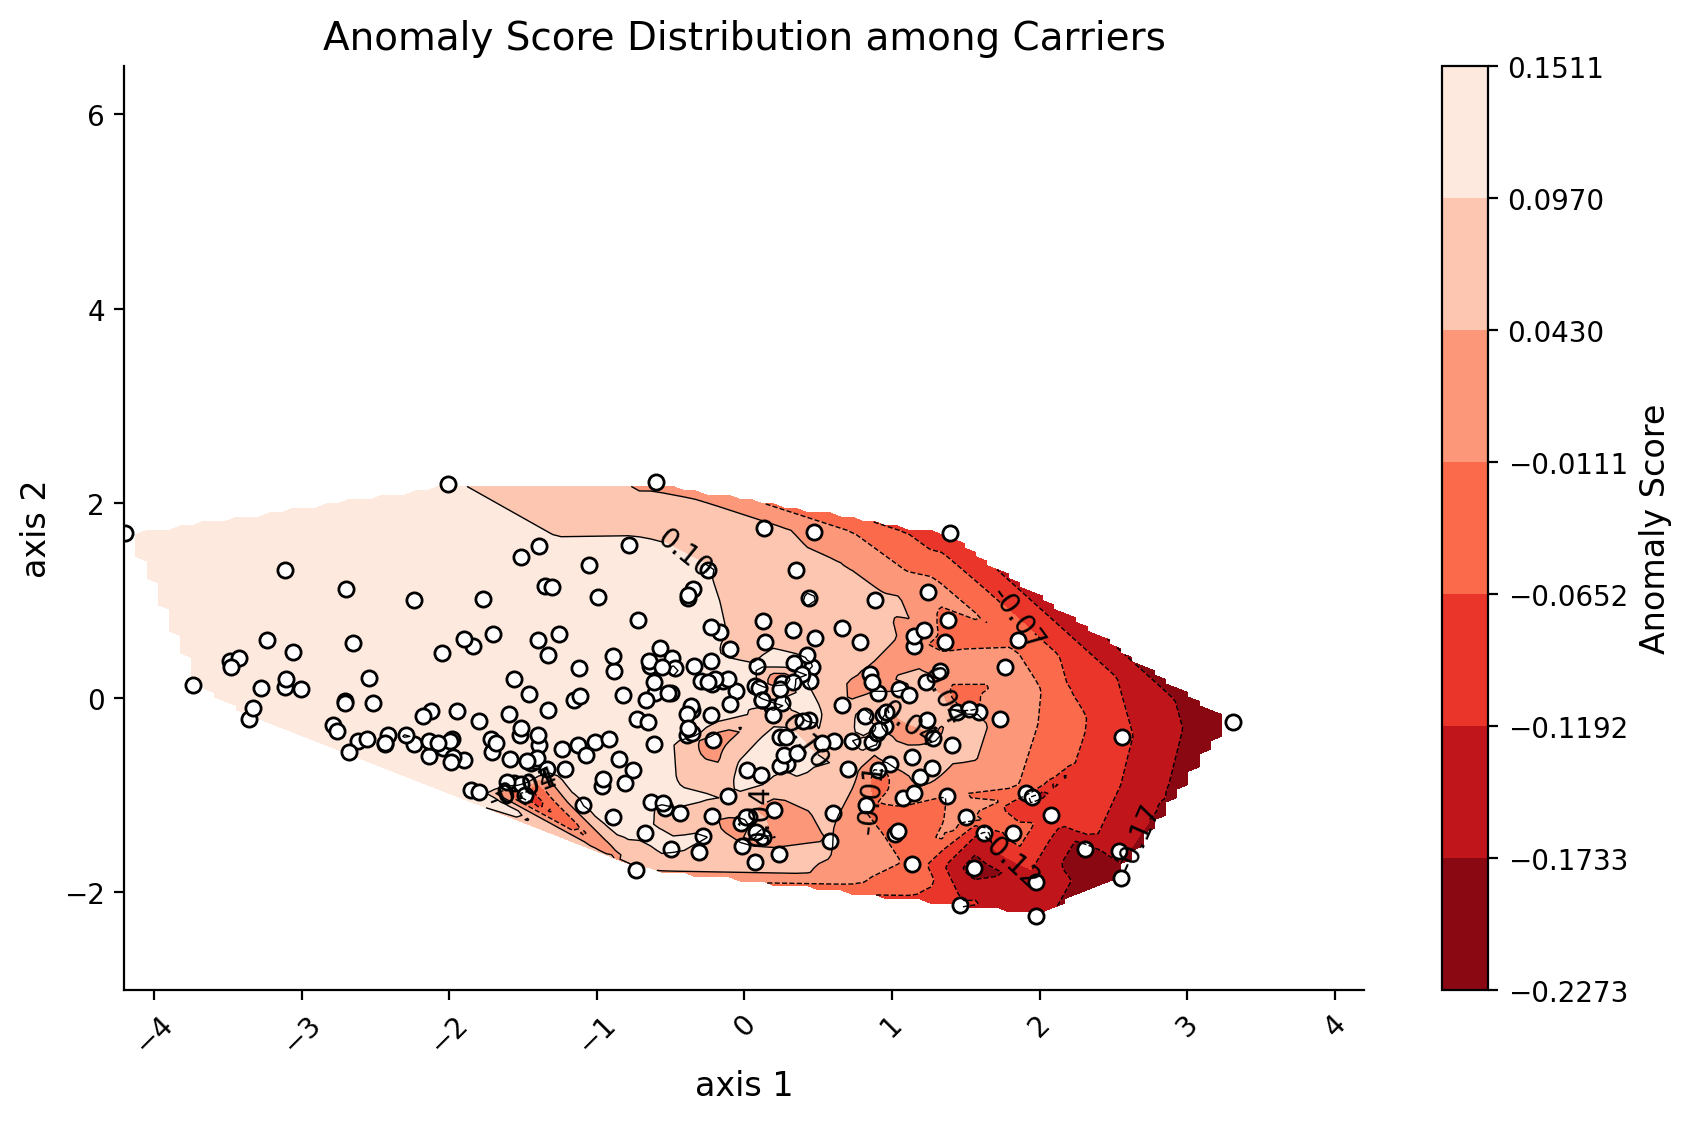

In [85]:
len(pls_carriers), len(carrier_log)

# Create mesh grid
x_min, x_max = feature_x.min(), feature_x.max()
y_min, y_max = feature_y.min(), feature_y.max()
X, Y = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Interpolate Z values
Z_interp = griddata((feature_x, feature_y), Z, (X, Y), method='linear')

# Plotting
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)

# Define a range of levels within threshold range
levels = np.linspace(Z.min(), Z.max(), 8)  

# Plot the contour 
contour_filled = ax.contourf(X, Y, Z_interp, levels=levels, cmap=plt.cm.Reds_r)
# cbar = plt.colorbar(contour_filled)
# cbar.ax.tick_params(labelsize=10)  
# cbar.set_label('Anomaly Score', fontsize=12)


for i, j in zip(feature_x, feature_y):
     ax.scatter(i, j, s = 30, color = "black", fc = "white")

# Add contour lines
contour_lines = ax.contour(X, Y, Z_interp, levels=levels, colors='black', linewidths=0.5)
ax.clabel(contour_lines, inline=True, fontsize=10, fmt='%1.2f')

ax.set_title('Anomaly Score Distribution among Carriers', fontsize=14)
ax.set_xlabel('axis 1', fontsize=12)
ax.set_ylabel('axis 2', fontsize=12)

cbar = plt.colorbar(contour_filled)
cbar.ax.tick_params(labelsize=10)  
cbar.set_label('Anomaly Score', fontsize=12)

ax.set_xlim(-4.2, 4.2)
ax.set_ylim(-3, 6.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.show()

## 5.3. Anomaly score vs Feature value of Anomaly carriers

In [86]:
index_list = actual_anomalies_carrier.index.tolist()

anomalous_data_carrier = actual_anomalies_carrier.copy()

# get the index of the rows of anomalous_data
anomalous_indices_carrier = anomalous_data_carrier.index
#actual_anomalies_carrier.to_csv('actual_anomalies_carrier.csv', index=True)

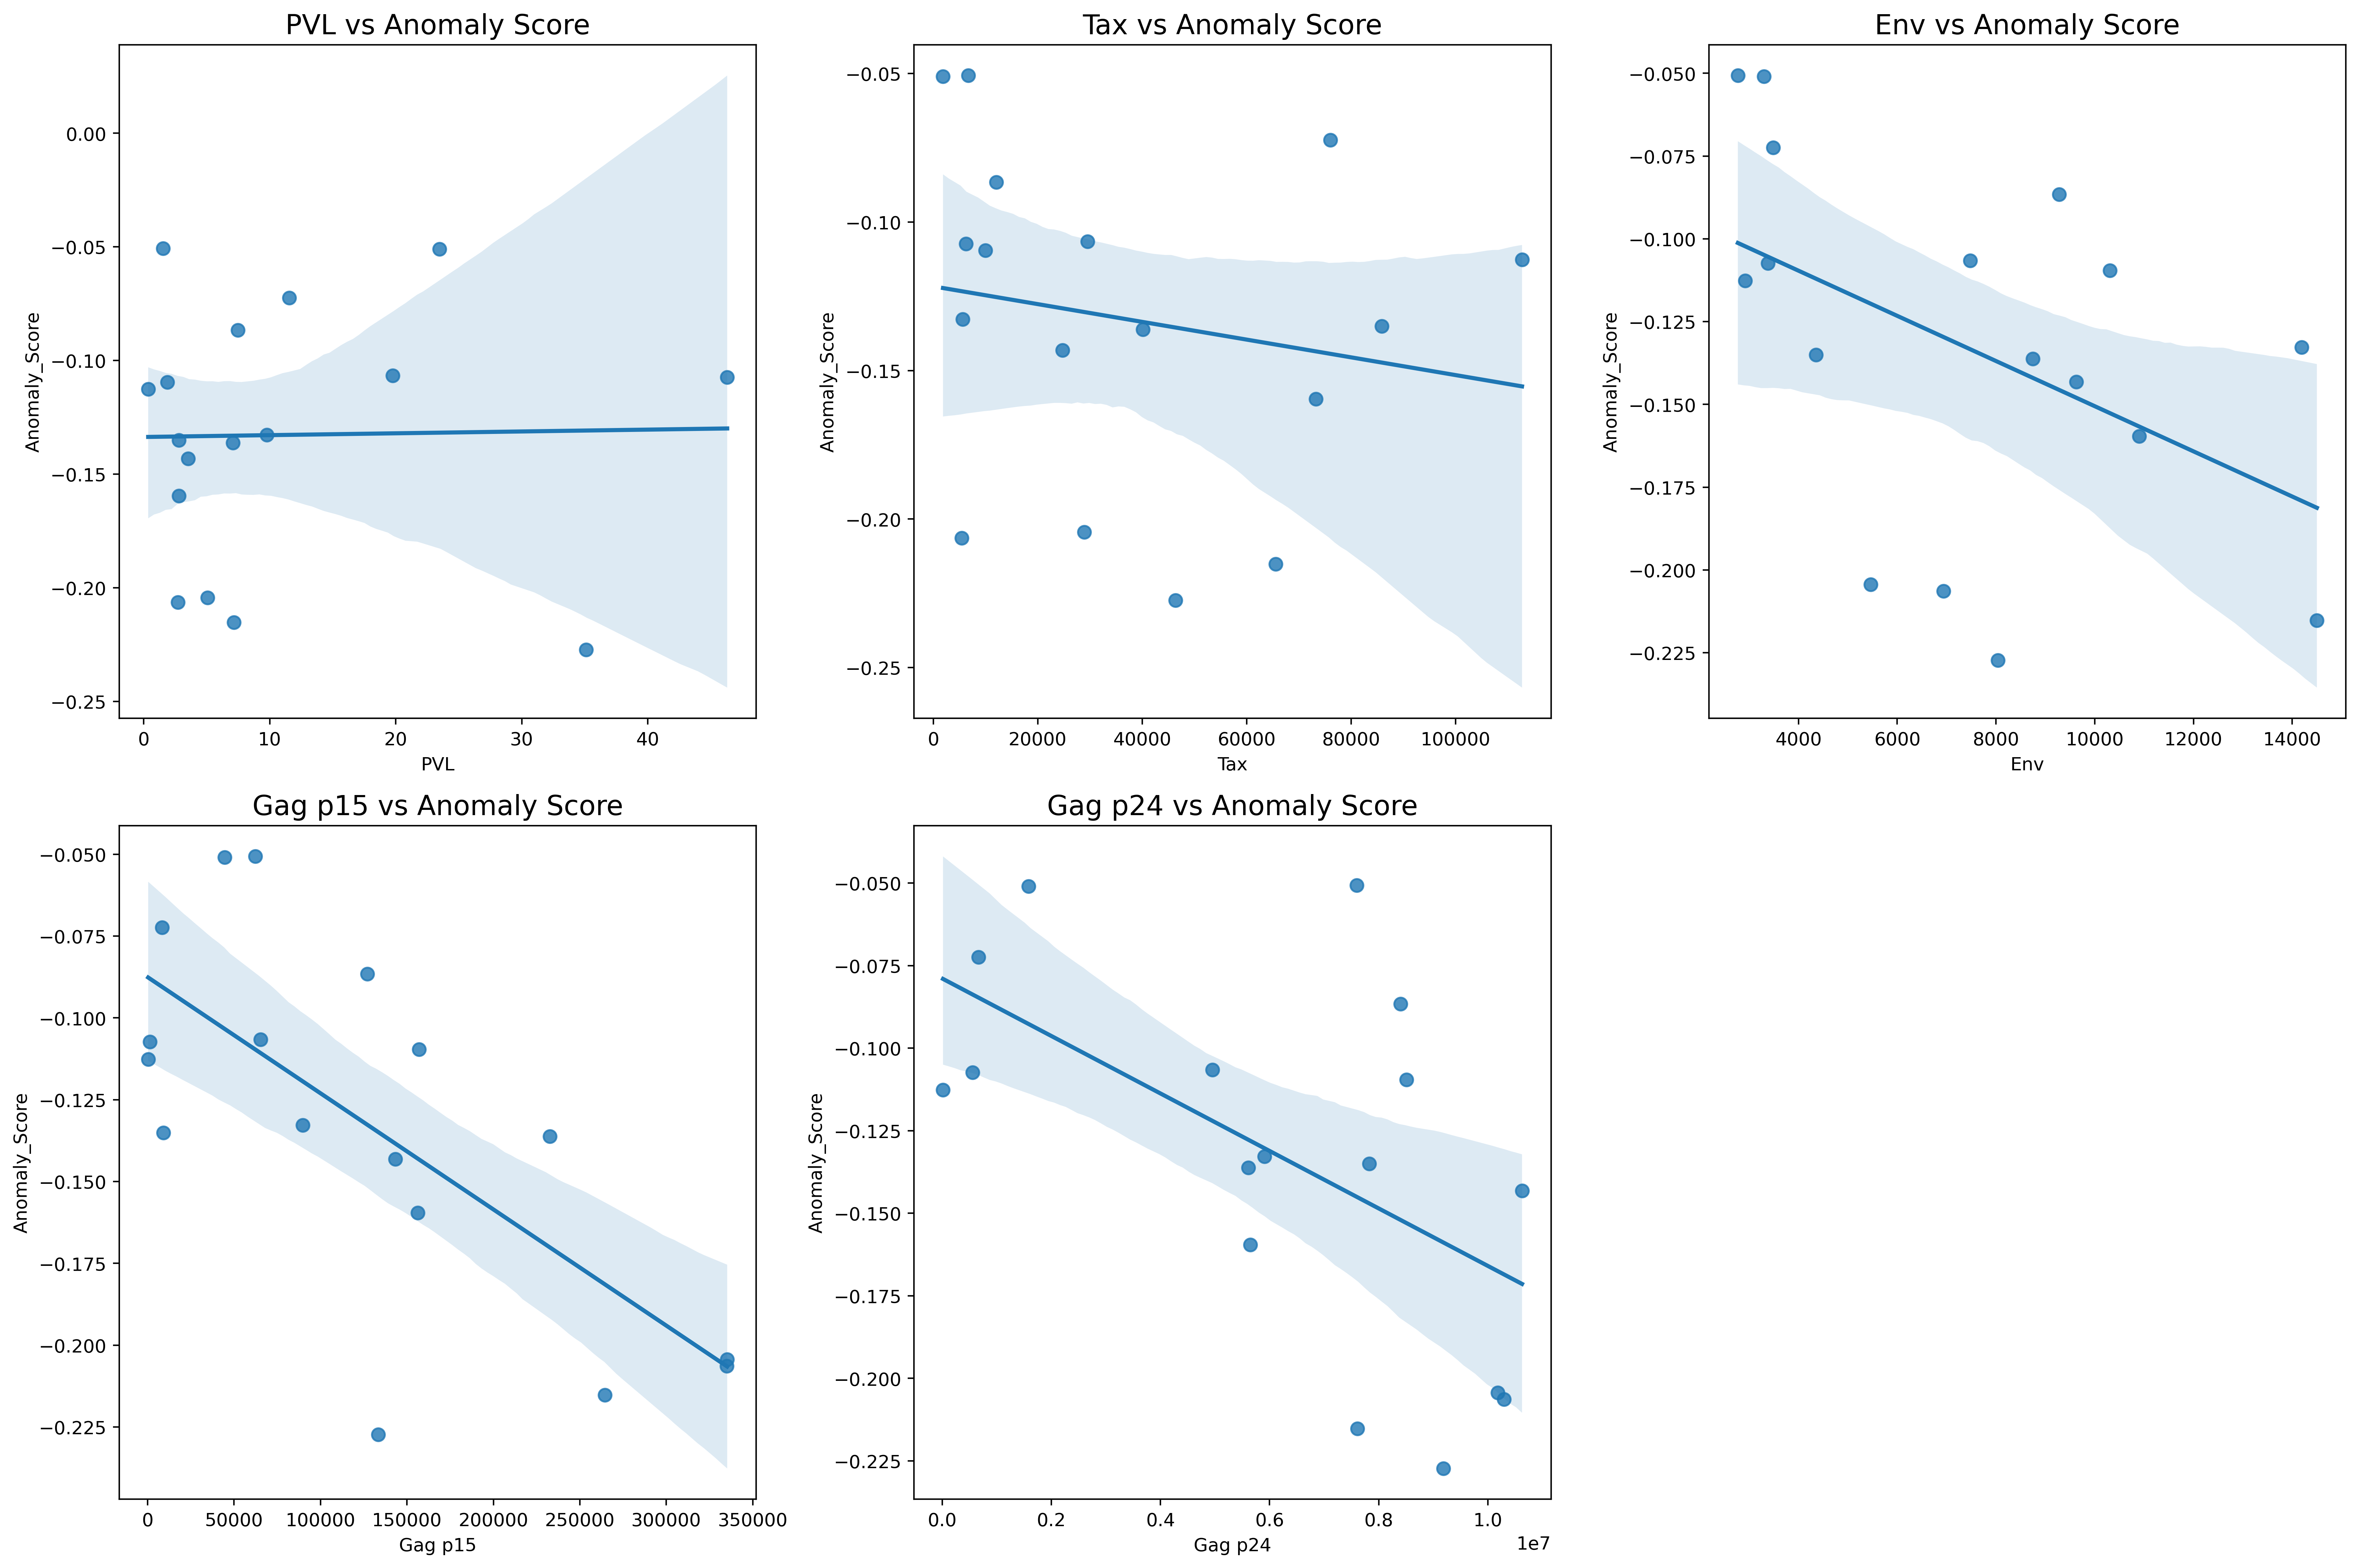

In [87]:
# Set up figures with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12), dpi= 400)

# Plotting each feature against anomaly score with 95% CI
sns.regplot(x='PVL', y='Anomaly_Score', data=actual_anomalies_carrier, ax=axes[0, 0], scatter_kws={'s': 50}, ci=95)
axes[0, 0].set_title('PVL vs Anomaly Score', fontsize=15)

sns.regplot(x='Tax', y='Anomaly_Score', data=actual_anomalies_carrier, ax=axes[0, 1], scatter_kws={'s': 50}, ci=95)
axes[0, 1].set_title('Tax vs Anomaly Score', fontsize=15)

sns.regplot(x='Env', y='Anomaly_Score', data=actual_anomalies_carrier, ax=axes[0, 2], scatter_kws={'s': 50}, ci=95)
axes[0, 2].set_title('Env vs Anomaly Score', fontsize=15)

sns.regplot(x='Gag p15', y='Anomaly_Score', data=actual_anomalies_carrier, ax=axes[1, 0], scatter_kws={'s': 50}, ci=95)
axes[1, 0].set_title('Gag p15 vs Anomaly Score', fontsize=15)

sns.regplot(x='Gag p24', y='Anomaly_Score', data=actual_anomalies_carrier, ax=axes[1, 1], scatter_kws={'s': 50}, ci=95)
axes[1, 1].set_title('Gag p24 vs Anomaly Score', fontsize=15)

axes[1, 2].set_visible(False)

fig.tight_layout() 
plt.show()

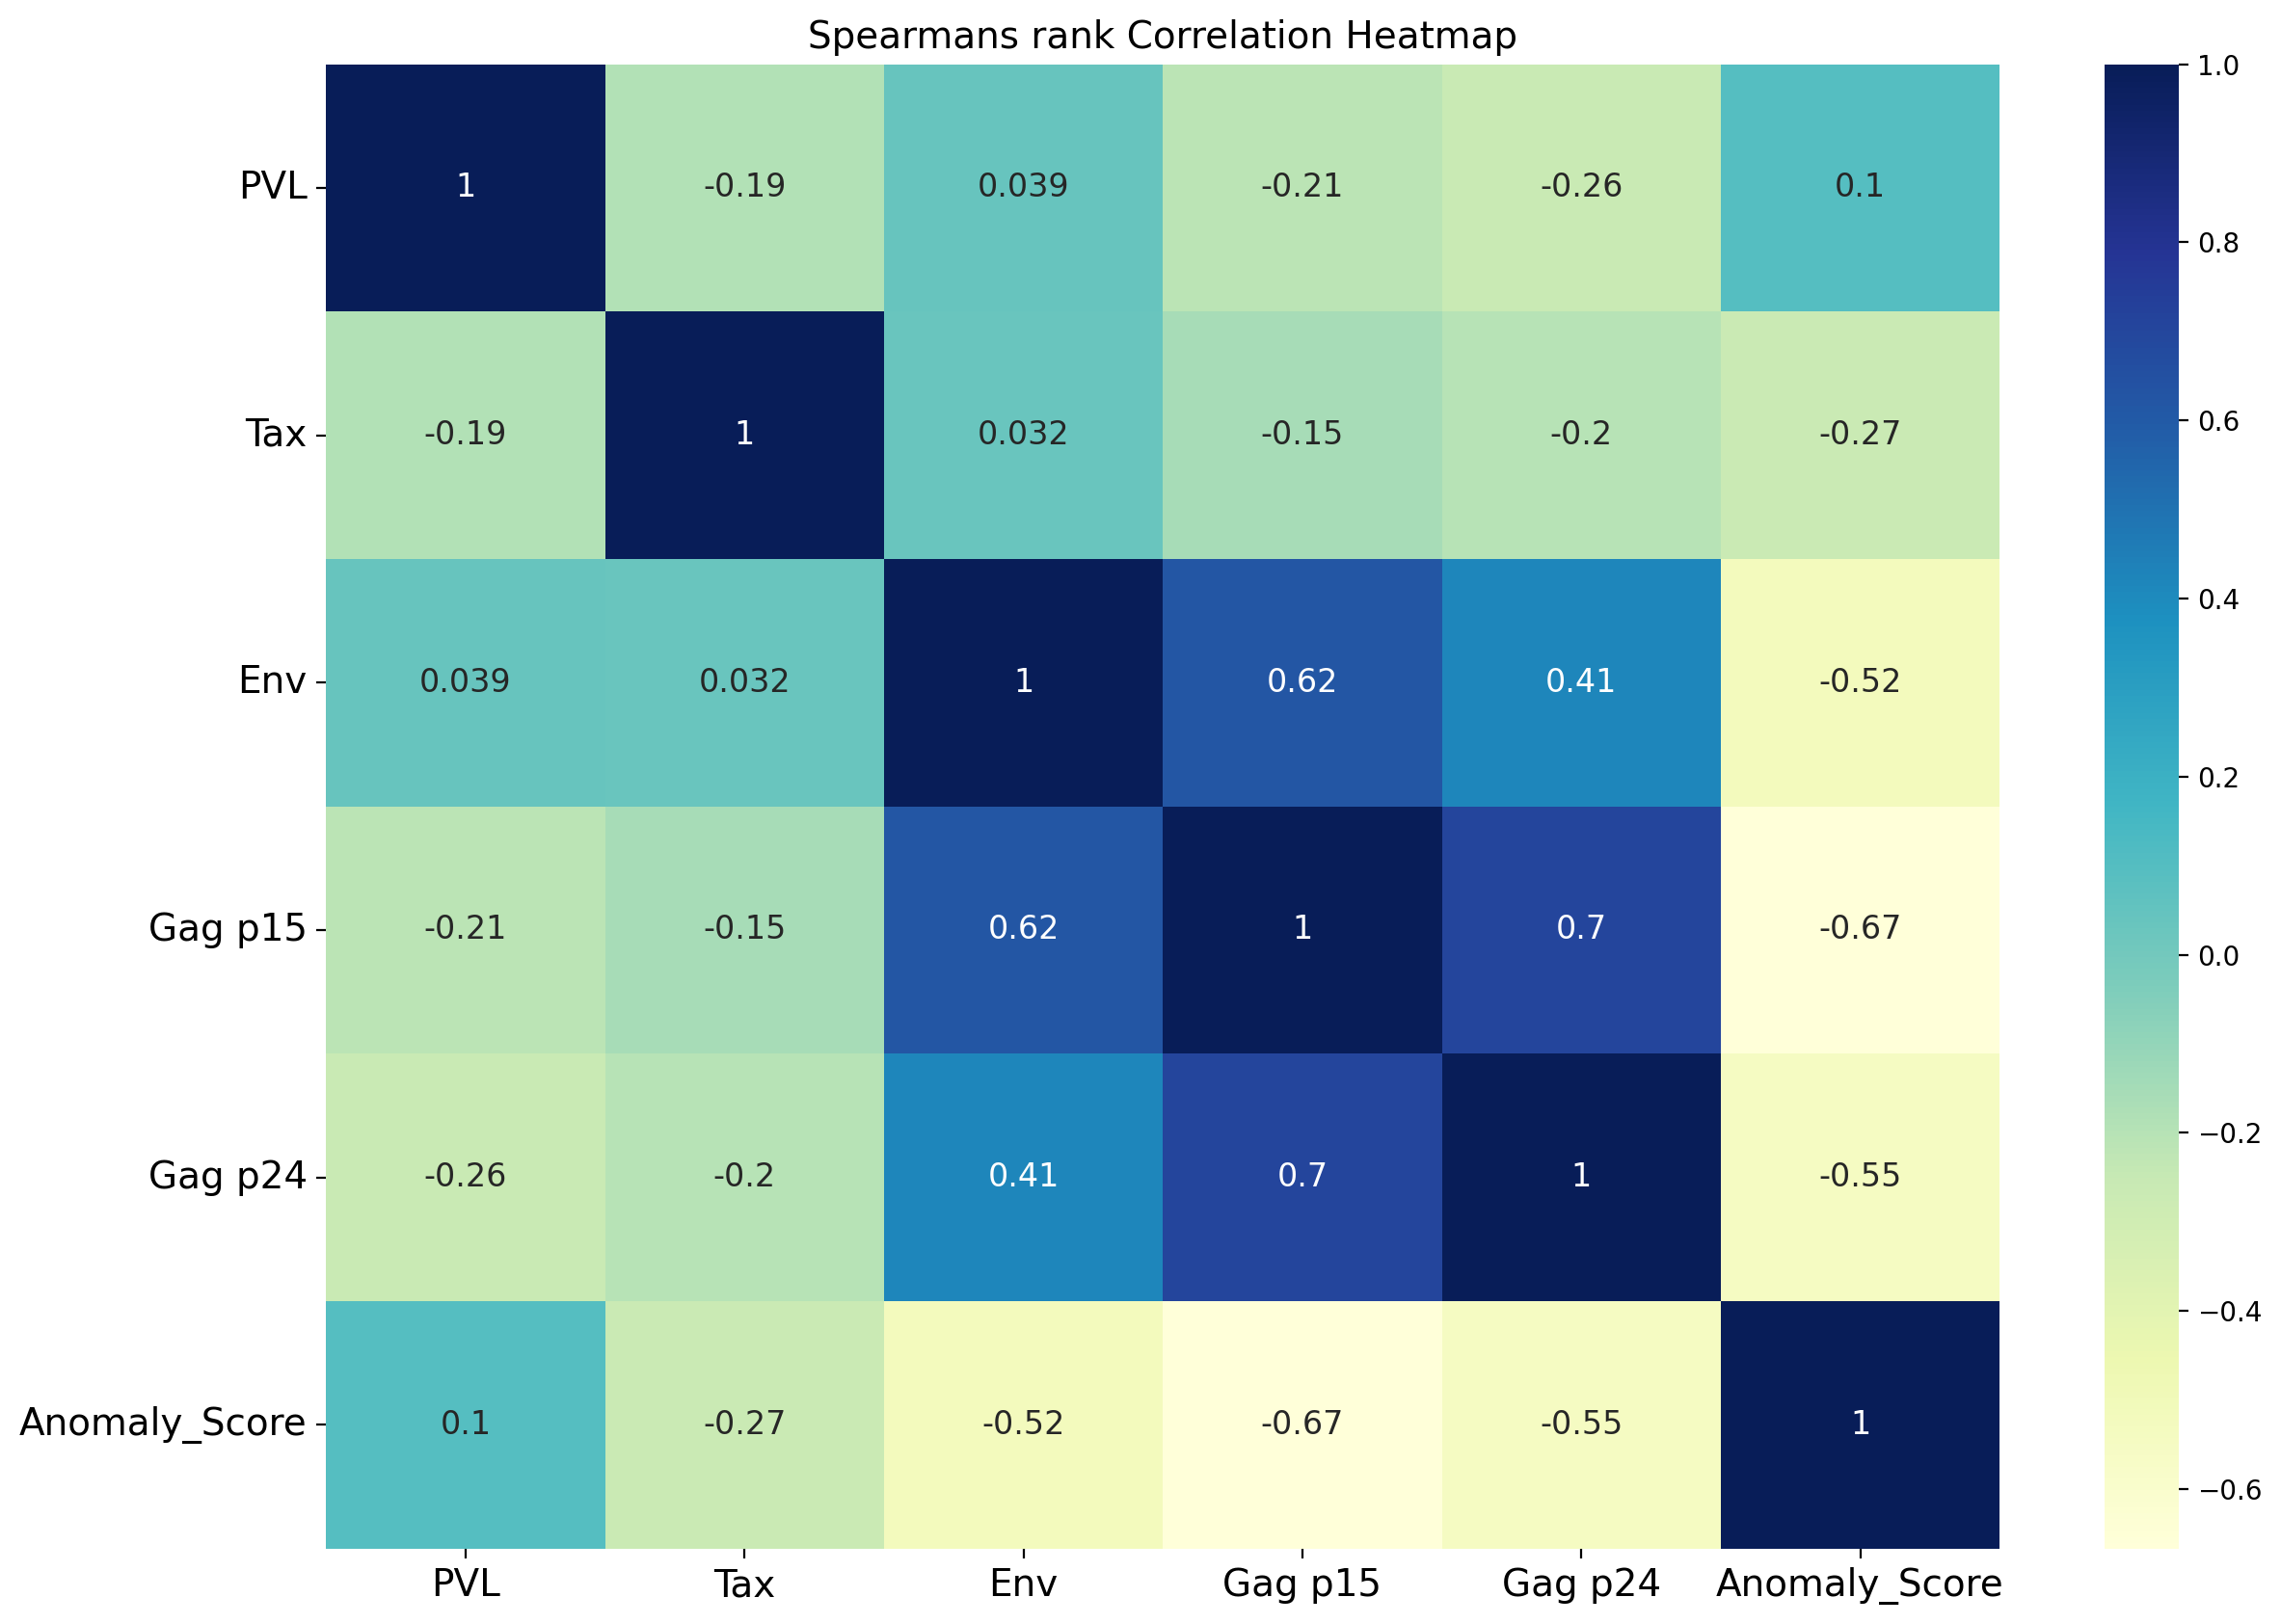

In [88]:
#correlation analysis
ascor_spearman = actual_anomalies_carrier.corr(method='spearman')
fig, ax = plt.subplots(figsize=(14, 10), dpi=200)
heatmap = sns.heatmap(ascor_spearman, cmap='YlGnBu', annot=True, annot_kws={'size': 12}, ax=ax)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=14)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=14, rotation=0)
plt.title('Spearmans rank Correlation Heatmap', fontsize=14)
plt.show()

In [89]:
rho_p15, p_p15 = spearmanr(actual_anomalies_carrier['Gag p15'], actual_anomalies_carrier['Anomaly_Score'])
rho_p24, p_p24 = spearmanr(actual_anomalies_carrier['Gag p24'], actual_anomalies_carrier['Anomaly_Score'])
rho_env, p_env = spearmanr(actual_anomalies_carrier['Env'], actual_anomalies_carrier['Anomaly_Score'])
rho_tax, p_tax = spearmanr(actual_anomalies_carrier['Tax'], actual_anomalies_carrier['Anomaly_Score'])
rho_pvl, p_pvl = spearmanr(actual_anomalies_carrier['PVL'], actual_anomalies_carrier['Anomaly_Score'])

In [90]:
print(rho_p15), print(rho_p24), print(rho_env), print(rho_tax), print(rho_pvl)

-0.6666666666666667
-0.5490196078431373
-0.5196078431372549
-0.26715686274509803
0.10049019607843139


(None, None, None, None, None)

In [91]:
print(p_p15),  print(p_p24), print(p_env), print(p_tax), print(p_pvl)

0.0034699602434103967
0.022461151768182565
0.03253716699175945
0.29991791209590246
0.7011667687510688


(None, None, None, None, None)

## 5.4. Correlation between Feature values & Predicted probability of HAM among Anomaly carriers

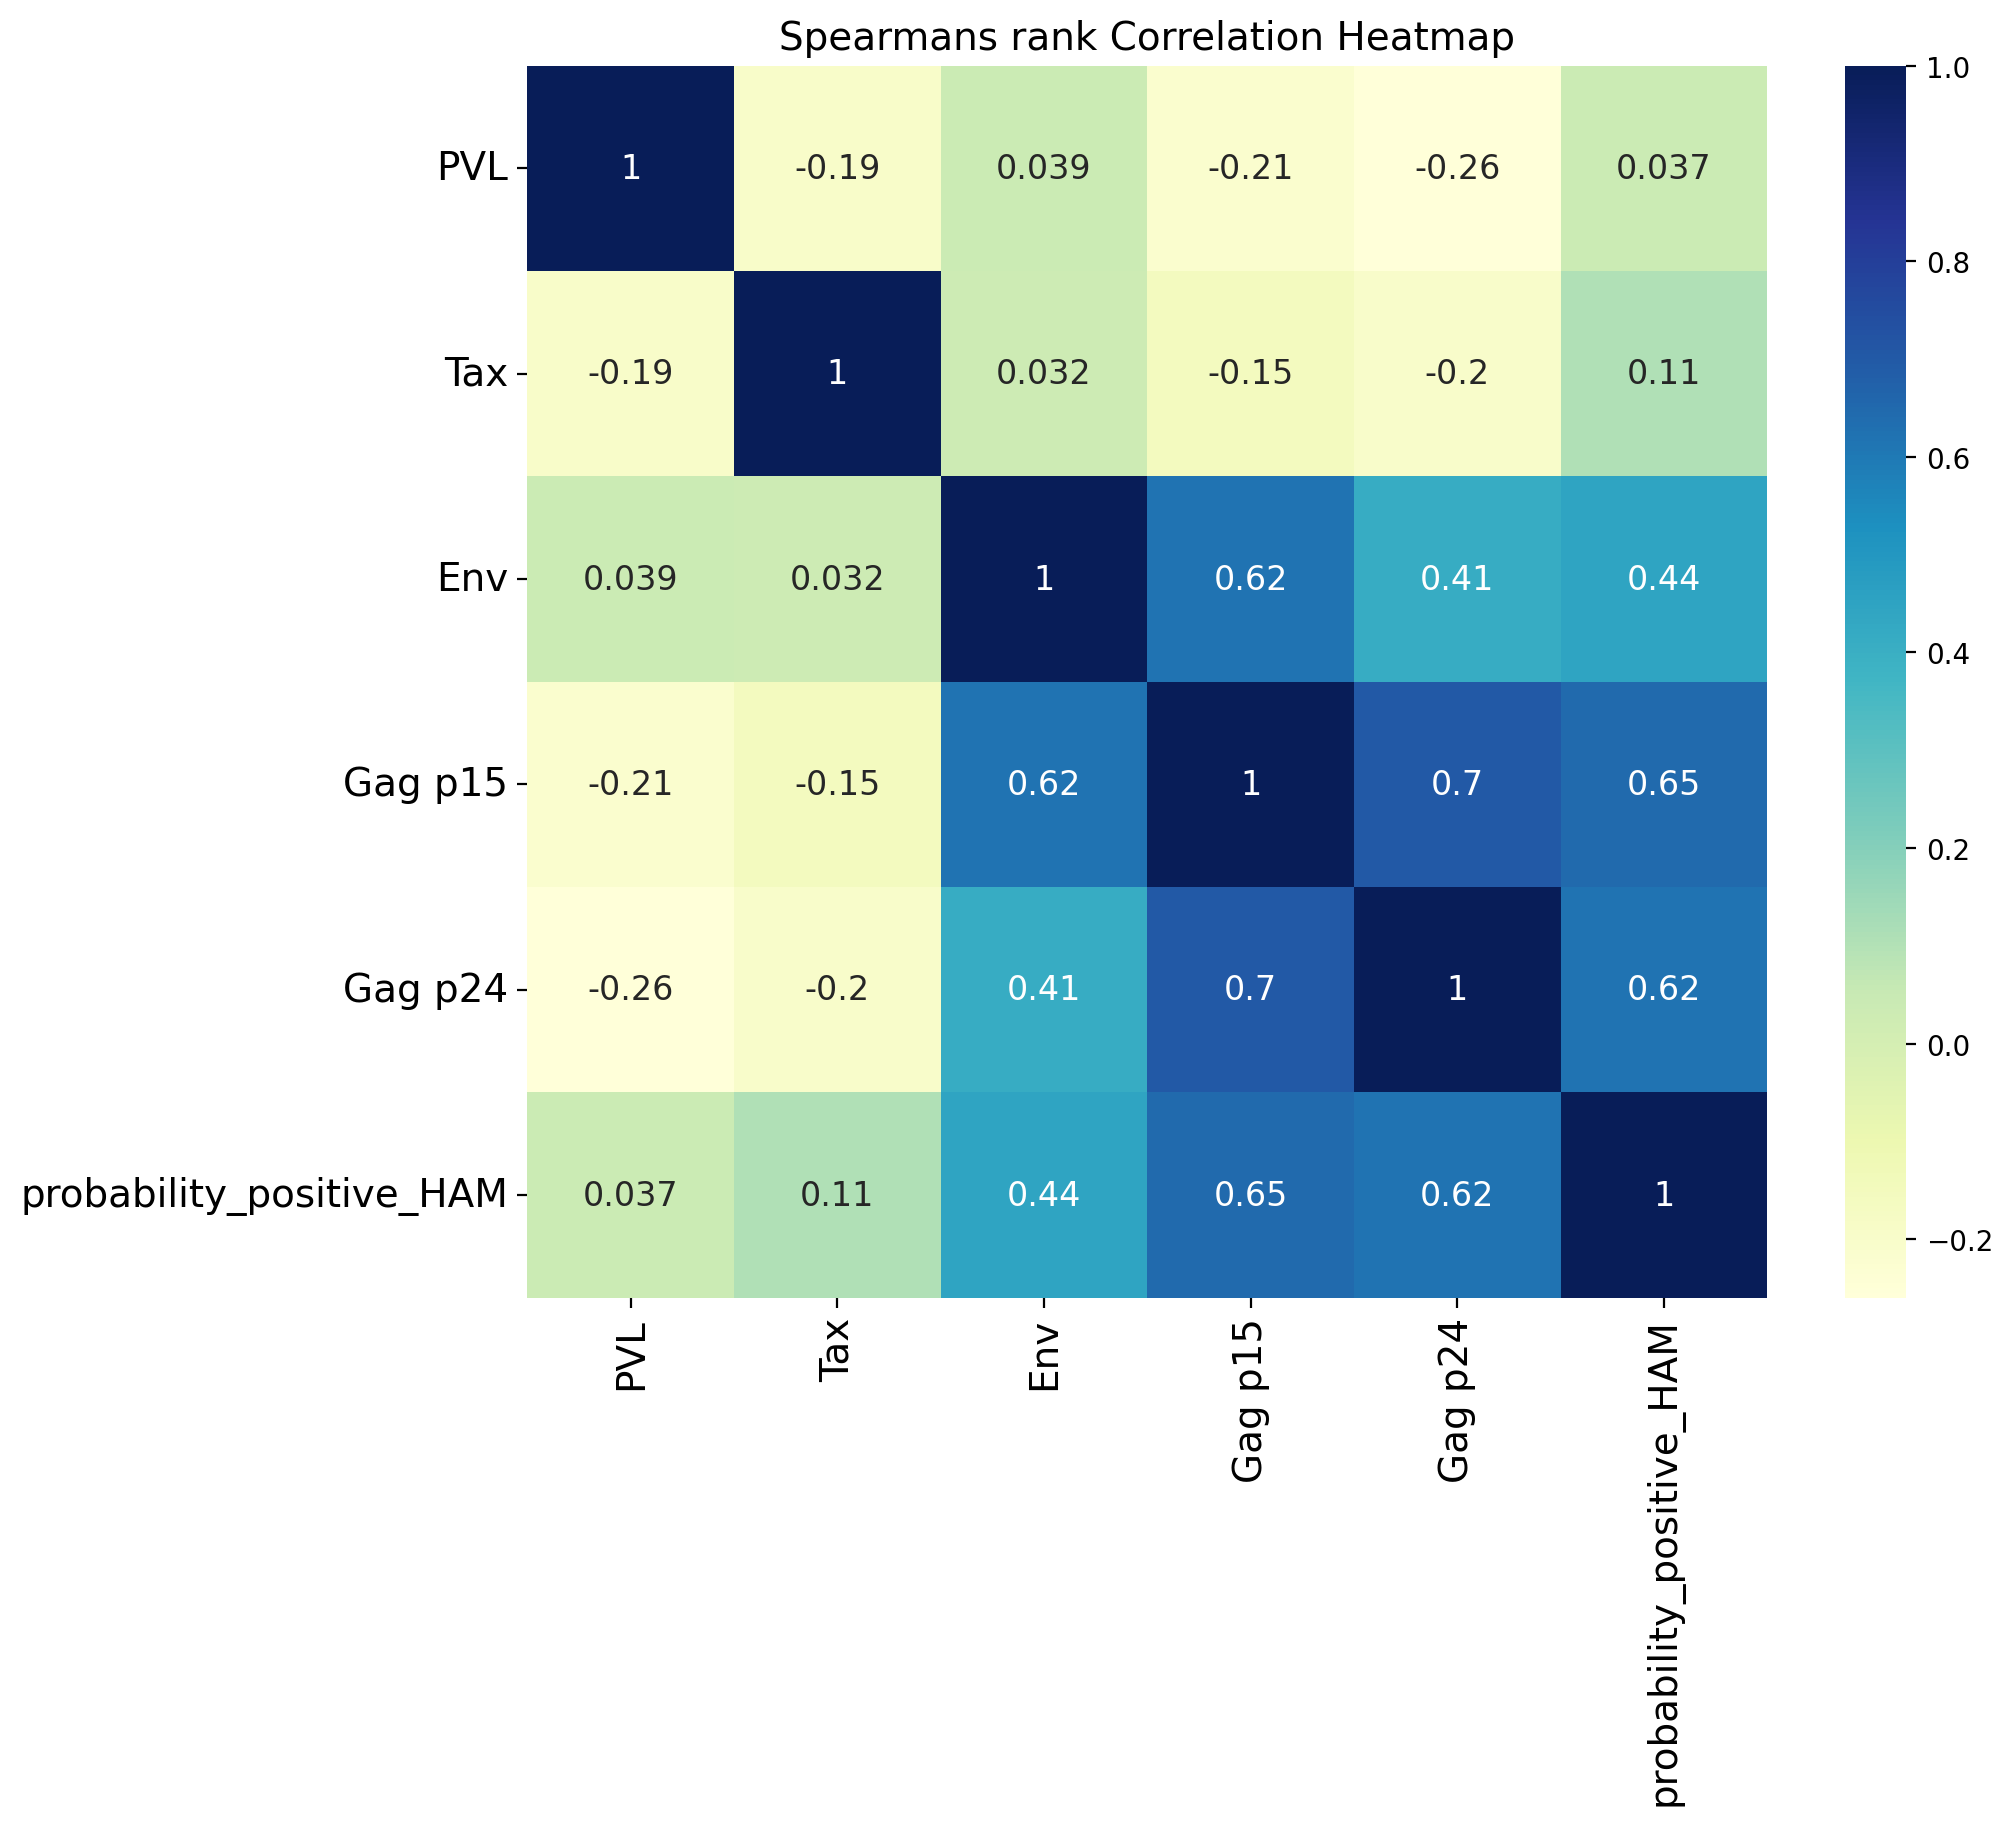

In [92]:
acppr = AC_pp_result.corr(method='spearman')
fig, ax = plt.subplots(figsize=(10, 8), dpi=200)
heatmap = sns.heatmap(acppr, cmap='YlGnBu', annot=True, annot_kws={'size': 12}, ax=ax)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=14)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=14)
plt.title('Spearmans rank Correlation Heatmap', fontsize=14)
plt.show()

In [93]:
rho_p24, p_value_p24 = spearmanr(AC_pp_result['Gag p24'], AC_pp_result['probability_positive_HAM'])
rho_tax, p_value_tax = spearmanr(AC_pp_result['Tax'], AC_pp_result['probability_positive_HAM'])
rho_p15, p_value_p15 = spearmanr(AC_pp_result['Gag p15'], AC_pp_result['probability_positive_HAM'])
rho_env, p_value_env = spearmanr(AC_pp_result['Env'], AC_pp_result['probability_positive_HAM'])
rho_pvl, p_value_pvl = spearmanr(AC_pp_result['PVL'], AC_pp_result['probability_positive_HAM'])

In [94]:
print(rho_p24), print(rho_tax), print(rho_p15), print(rho_env), print(rho_pvl)

0.6183188386375321
0.10817506520895195
0.6490503912537117
0.4449928818822796
0.036877863139415434


(None, None, None, None, None)

In [95]:
print(p_value_p24), print(p_value_tax), print(p_value_p15), print(p_value_env),print(p_value_pvl)

0.008152823519178851
0.6794157207870973
0.004815860899779107
0.07347485449881916
0.8882519846273782


(None, None, None, None, None)

## 6. Required packages

In [96]:
# package versions
import pkg_resources

dependencies = ['scikit-learn', 'scikit-posthocs', 'numpy', 'pandas', 'matplotlib', 'seaborn', 'scipy', 'statsmodels', 'xgboost']  
for package in dependencies:
    try:
        version = pkg_resources.get_distribution(package).version
        print(f"{package}=={version}")
    except:
        print(f"{package} not installed")

scikit-learn==1.5.2
scikit-posthocs==0.11.0
numpy==1.24.4
pandas==2.2.3
matplotlib==3.9.2
seaborn==0.13.2
scipy==1.13.1
statsmodels==0.14.4
xgboost==2.1.3


In [97]:
import notebook
print(notebook.__version__)

7.2.2


In [98]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.12.3
ipykernel        : 6.29.5
ipywidgets       : 8.1.5
jupyter_client   : 8.6.3
jupyter_core     : 5.7.2
jupyter_server   : 2.14.2
jupyterlab       : 4.2.6
nbclient         : 0.10.1
nbconvert        : 7.16.4
nbformat         : 5.10.4
notebook         : 7.2.2
qtconsole        : 5.6.1
traitlets        : 5.14.3
